# Estimating Exposure to Police from Dashcam Data 
Matt Franchi, Jan 2023 

This notebook contains all work needed to generate paper materials for the FAccT 2023 conference. 

## 0. Module Imports 

In [2]:
from pprint import pprint
import pandas as pd 
import geopandas as gpd
import numpy as np 
from tqdm import tqdm
from zoneinfo import ZoneInfo
import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import pearsonr, spearmanr
import datetime
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
from scipy.stats import bootstrap
from tqdm.auto import tqdm
tqdm.pandas()
import seaborn as sns 

## (Optional) Enable LaTeX font rendering 

In [3]:
# Requires local LaTeX installation 
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman']})
matplotlib.rcParams['text.usetex'] = True
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage[T1]{fontenc}')


## Global Constants 

### I/O Paths

In [4]:
ANL_DATASET_PATH = "/share/pierson/nexar_data/nexar_yolov7/intermediate_notebooks/analysis_dataset.csv"
FIRST_CHUNK_PATH = "/share/pierson/nexar_data/nypd-deployment-patterns/output/1603771200000.csv"
VALSET_PATH = "/share/pierson/nexar_data/dashcam-analysis/final_model_metrics/valset_2.csv"
TESTSET_PATH = "/share/pierson/nexar_data/nexar_yolov7/test_set.csv"
PAPER_GIT_REPO_PATH = "/share/pierson/nexar_data/nypd-deployment-patterns/plots"

### Geographic 

In [5]:
WGS = 'EPSG:4326'
PROJ_CRS = 'EPSG:2263'
NYC_COUNTY_CODES = ['005', '047', '061', '081', '085']

### Analysis Parameters 

In [6]:
BASE_CHUNKS_PATH = '/share/pierson/nexar_data/FINAL_CHUNKS/%i.csv'
COLS_TO_DEDUPLICATE_ON = ['lat', 'lng', 'timestamp'] # columns to use to check for duplicates
MIN_DATE_FOR_DEMOGRAPHIC_ANALYSIS = datetime.datetime(2020, 10, 5, 0, 0, 0, tzinfo=ZoneInfo('US/Eastern')) # don't use data before this data to analyze disparities / demographics
POSITIVE_CLASSIFICATION_THRESHOLD = 0.770508 # threshold to define a positive prediction
LOCATION_COL_TO_GROUP_ON = 'GEOID20' # This should be the name of the column we're analyzing location grouping at - e.g., corresponding to Census Block Group or Census tract. CHECKED
TOTAL_POPULATION_COL = 'Estimate_Total' # needs to match whether using Census tract or Block group. [Answer: CBG]
WHITE_POPULATION_COL = 'Estimate_Total_Not_Hispanic_or_Latino_White_alone'
BLACK_POPULATION_COL = 'Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone'
ASIAN_POPULATION_COL = 'Estimate_Total_Not_Hispanic_or_Latino_Asian_alone'
HISPANIC_POPULATION_COL = 'Estimate_Total_Hispanic_or_Latino'
POPULATION_COUNT_COLS = [WHITE_POPULATION_COL, BLACK_POPULATION_COL, ASIAN_POPULATION_COL, HISPANIC_POPULATION_COL, TOTAL_POPULATION_COL]
TIME_AND_DATE_COL = 'time_and_date_of_image'
DEMOGRAPHIC_COLS = ['density_cbg', # things we want to look at correlations with. Demographic cols may not be best name. 
                    'black_frac',
                    'white_frac', 
                    'distance_from_nearest_crime_6hr',
                    'distance_from_nearest_police_station',
                    'median_household_income']
PREDICTION_COLS = ['above_threshold', 'calibrated_prediction', 'prediction_adjusted_for_police_station_distance'] # columns with police car predictions. We define these
MIN_POPULATION_IN_AREA = 500
BOROUGH_COL = 'boroname'
NEIGHBORHOOD_COL = 'ntaname'

## 1. Dataset Verification 

In [7]:
# Load in annotated dataset from disk 
#d = pd.concat([chunk for chunk in tqdm(pd.read_csv(ANL_DATASET_PATH, chunksize=100000), total=221, desc='Loading data')])
# Variant: no progress bar, use faster pyarrow engine
#d = pd.read_csv(ANL_DATASET_PATH, engine='pyarrow')

# ALT. Only load first chunk. 
d = pd.concat([chunk for chunk in tqdm(pd.read_csv(FIRST_CHUNK_PATH, chunksize=100000), total=5, desc='Loading data')])




Loading data:   0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
d.head()

,image_ref,timestamp,lat,lng,split,conf,has_prediction,time_and_date_of_image,hour,day_of_week,...,Pop_20,BCT2020,GeoID,Hsp_20P,WNH_20P,BNH_20P,ANH_20P,ONH_20P,NH2pl_20P,density_tract
0,ride/9595d53f77af1a4c9037af21533f1459/fod_3C88...,1603856888221,40.883900,-73.848427,1,NaN,NaN,2020-10-27 23:48:08.221000-04:00,23,1,...,5662.0,2045800.0,3.600505e+10,57.8,0.8,38.5,0.5,0.6,1.7,61121.586692
1,ride/9595d53f77af1a4c9037af21533f1459/fod_AAE9...,1603856857835,40.883900,-73.848427,1,NaN,NaN,2020-10-27 23:47:37.835000-04:00,23,1,...,5662.0,2045800.0,3.600505e+10,57.8,0.8,38.5,0.5,0.6,1.7,61121.586692
2,ride/415c10f519ed18435db5b42ad7d96b74/fod_6C55...,1603841985550,40.883992,-73.848646,1,NaN,NaN,2020-10-27 19:39:45.550000-04:00,19,1,...,5662.0,2045800.0,3.600505e+10,57.8,0.8,38.5,0.5,0.6,1.7,61121.586692
3,ride/0ce8e5f76cd4bec943ccbef2964ef0e0/fod_2020...,1603802823000,40.883911,-73.848455,1,NaN,NaN,2020-10-27 08:47:03-04:00,8,1,...,5662.0,2045800.0,3.600505e+10,57.8,0.8,38.5,0.5,0.6,1.7,61121.586692
4,ride/006778bbe3c3d75bd4a3add9d6a7fe4b/fod_2020...,1603847195167,40.886703,-73.862242,1,NaN,NaN,2020-10-27 21:06:35.167000-04:00,21,1,...,4647.0,2039400.0,3.600504e+10,35.6,3.2,56.1,1.4,1.8,1.9,82993.624991


### Preprocessing

In [9]:
# Convert dt column to EST timezone 
d.time_and_date_of_image = pd.to_datetime(d.time_and_date_of_image)
d.time_and_date_of_image = d.time_and_date_of_image.dt.tz_convert('US/Eastern')
print("Descriptive stats for datetimes in dataset.")
print(d.time_and_date_of_image.describe(datetime_is_numeric=True))
print('─' * 50)


# Inspect columns 
print("Columns in d: ")
pprint(list(d.columns.values), width=120, compact=True)

Descriptive stats for datetimes in dataset.
count                                 433146
mean     2020-10-27 14:39:25.093061888-04:00
min         2020-10-27 00:00:00.403000-04:00
25%      2020-10-27 10:34:43.934249984-04:00
50%      2020-10-27 15:29:56.585000192-04:00
75%      2020-10-27 18:51:34.171500032-04:00
max         2020-10-27 23:59:59.481000-04:00
Name: time_and_date_of_image, dtype: object
──────────────────────────────────────────────────
Columns in d: 
['image_ref', 'timestamp', 'lat', 'lng', 'split', 'conf', 'has_prediction', 'time_and_date_of_image', 'hour',
 'day_of_week', 'day_of_month', 'month', 'weekend', 'phase', 'nighttime', 'geometry', 'point_of_nearest_crime_1hr',
 'desc_of_nearest_crime_1hr', 'time_of_nearest_crime_1hr', 'distance_from_nearest_crime_1hr',
 'point_of_nearest_crime_3hr', 'desc_of_nearest_crime_3hr', 'time_of_nearest_crime_3hr',
 'distance_from_nearest_crime_3hr', 'point_of_nearest_crime_6hr', 'desc_of_nearest_crime_6hr',
 'time_of_nearest_crime_6hr

In [10]:
# Remove duplicates. 
duplicate_idxs = d.duplicated(subset=COLS_TO_DEDUPLICATE_ON)
print("warning: %i duplicates identified using %s, fraction %2.6f of rows; dropping rows" % (duplicate_idxs.sum(), COLS_TO_DEDUPLICATE_ON, duplicate_idxs.mean()))
d = d.loc[~duplicate_idxs].copy()

def household_income_map(x):
    if x == '-' or x == '':
        return None
    elif x == '250,000+':
        return 250000
    elif x == '2,500-':
        return 2500
    return float(x)

d['GeoID'] = d['GeoID'].astype(str)

# define Census variables
d['median_household_income'] = d['median_household_income'].map(household_income_map)
d['white_frac'] = d[WHITE_POPULATION_COL] / d[TOTAL_POPULATION_COL]
d['black_frac'] = d[BLACK_POPULATION_COL] / d[TOTAL_POPULATION_COL]
assert d['white_frac'].dropna().max() <= 1
assert d['white_frac'].dropna().min() >= 0
assert d['black_frac'].dropna().max() <= 1
assert d['black_frac'].dropna().min() >= 0

# define time variables
#d['date'] = d[TIME_AND_DATE_COL].map(lambda x:datetime.datetime.strptime(x.split()[0], '%Y-%m-%d'))
d['date'] = d[TIME_AND_DATE_COL].dt.date
locations_by_date = d.groupby('date')[LOCATION_COL_TO_GROUP_ON].nunique()
print('unique locations by', locations_by_date)

# filter for dates with full coverage. 
print("In demographic analysis, filtering for locations after %s because more geographically representative" % MIN_DATE_FOR_DEMOGRAPHIC_ANALYSIS)
d_for_demo_analysis = d.loc[d['phase'] == 1].copy()
print("%i/%i rows remaining" % (len(d_for_demo_analysis), len(d)))




unique locations by date
2020-10-27    6522
Name: GEOID20, dtype: int64
In demographic analysis, filtering for locations after 2020-10-05 00:00:00-04:00 because more geographically representative
433146/433146 rows remaining


In [11]:
# FILLING IN NA DATA 
d.conf.fillna(0, inplace=True)

d.distance_from_nearest_police_station.fillna(0, inplace=True)
d.distance_from_nearest_crime_1hr.fillna(0,inplace=True)
d.distance_from_nearest_crime_3hr.fillna(0,inplace=True)
d.distance_from_nearest_crime_6hr.fillna(0,inplace=True)

d.density_cbg.fillna(0, inplace=True)
d["Estimate_Total"].fillna(0, inplace=True)
d["Estimate_Total_Not_Hispanic_or_Latino_White_alone"].fillna(0, inplace=True)
d["Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone"].fillna(0,inplace=True)
d["Estimate_Total_Not_Hispanic_or_Latino_Asian_alone"].fillna(0, inplace=True)
d["Estimate_Total_Hispanic_or_Latino"].fillna(0,inplace=True)

### Sanity Checks

In [12]:
# Check that all lng/lat coordinates are in range 
LNG_BOUNDS = (-78,-73)
LAT_BOUNDS = (40, 45)

lng_in_range = ((d.lng > LNG_BOUNDS[0]) & (d.lng < LNG_BOUNDS[1]))
print(f"{sum(lng_in_range)} / {len(d.index)} have in range longitudes.")
lat_in_range = ((d.lat > LAT_BOUNDS[0]) & (d.lat < LAT_BOUNDS[1]))
print(f"{sum(lat_in_range)} / {len(d.index)} have in range latitudes.")

assert lng_in_range.all()
assert lat_in_range.all()

433146 / 433146 have in range longitudes.
433146 / 433146 have in range latitudes.


In [13]:
# Missing data -- set threshold, print out columns with more than this percent missing 
NA_THRESHOLD = 0.025
print(f"Dataset columns with > {NA_THRESHOLD} proportion of missing images.")
pprint(d.loc[:, d.isnull().mean() > NA_THRESHOLD].isnull().mean())

Dataset columns with > 0.025 proportion of missing images.
has_prediction             0.806783
median_household_income    0.172365
cdeligibil                 1.000000
ANH_20P                    0.034794
ONH_20P                    0.035542
white_frac                 0.059717
black_frac                 0.059717
dtype: float64


In [14]:
# Checking that all core analysis columns fall within sensible value ranges 
CONF_BOUNDS = (0,1)

NTANAMES_LENGTH = 195 
DISTANCE_FROM_NEAREST_POLICE_STATION_BOUNDS=(0,50000)
DISTANCE_FROM_NEAREST_CRIME_BOUNDS=(0,500000)
MEDIAN_HOUSEHOLD_INCOME_BOUNDS=(0,100000000)
ESTIMATE_WHITE_BOUNDS = (0, 10000000)
ESTIMATE_BLACK_BOUNDS = (0, 10000000)
ESTIMATE_ASIAN_BOUNDS = (0, 10000000)
ESTIMATE_HISPANIC_BOUNDS = (0, 10000000)
DENSITY_BOUNDS = (0,10000000)
TIME_AND_DATE_OF_IMAGE_BOUNDS = (datetime.datetime(2020,3,1,0,0,0,tzinfo=ZoneInfo('US/Eastern')), datetime.datetime(2020,11,17,0,0,0,tzinfo=ZoneInfo('US/Eastern')))
HOUR_BOUNDS = (0,23)
DAY_OF_WEEK_BOUNDS = (0,6)
DAY_OF_MONTH_BOUNDS = (1,31)
WEEKEND_BOUNDS = (0,1)
NIGHTTIME_BOUNDS = (0,1)

# Model features
assert (d.conf >= CONF_BOUNDS[0]).all()
assert (d.conf < CONF_BOUNDS[1]).all()

# Demographic features 
#assert d.median_household_income > MEDIAN_HOUSEHOLD_INCOME_BOUNDS[0]
#assert d.median_household_income < MEDIAN_HOUSEHOLD_INCOME_BOUNDS[1]

assert (d.density_cbg >= DENSITY_BOUNDS[0]).all()
assert (d.density_cbg <= DENSITY_BOUNDS[1]).all()

assert (d["Estimate_Total_Not_Hispanic_or_Latino_White_alone"] >= ESTIMATE_WHITE_BOUNDS[0]).all()
assert (d["Estimate_Total_Not_Hispanic_or_Latino_White_alone"] <= ESTIMATE_WHITE_BOUNDS[1]).all()

assert (d["Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone"] >= ESTIMATE_BLACK_BOUNDS[0]).all()
assert (d["Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone"] <= ESTIMATE_BLACK_BOUNDS[1]).all()

#d["Estimate_Total_Not_Hispanic_or_Latino_Asian_alone"]

assert (d["Estimate_Total_Not_Hispanic_or_Latino_Asian_alone"] >= ESTIMATE_ASIAN_BOUNDS[0]).all()
assert (d["Estimate_Total_Not_Hispanic_or_Latino_Asian_alone"] <= ESTIMATE_ASIAN_BOUNDS[1]).all()

assert (d["Estimate_Total_Hispanic_or_Latino"] >= ESTIMATE_HISPANIC_BOUNDS[0]).all()
assert (d["Estimate_Total_Hispanic_or_Latino"] <= ESTIMATE_HISPANIC_BOUNDS[1]).all()

# Distance features 
assert (d.distance_from_nearest_police_station >= DISTANCE_FROM_NEAREST_POLICE_STATION_BOUNDS[0]).all()
assert (d.distance_from_nearest_police_station <= DISTANCE_FROM_NEAREST_POLICE_STATION_BOUNDS[1]).all()

assert (d.distance_from_nearest_crime_1hr >= DISTANCE_FROM_NEAREST_CRIME_BOUNDS[0]).all()
assert (d.distance_from_nearest_crime_1hr <= DISTANCE_FROM_NEAREST_CRIME_BOUNDS[1]).all()

assert (d.distance_from_nearest_crime_3hr >= DISTANCE_FROM_NEAREST_CRIME_BOUNDS[0]).all()
assert (d.distance_from_nearest_crime_3hr <= DISTANCE_FROM_NEAREST_CRIME_BOUNDS[1]).all()

assert (d.distance_from_nearest_crime_6hr >= DISTANCE_FROM_NEAREST_CRIME_BOUNDS[0]).all()
assert (d.distance_from_nearest_crime_6hr <= DISTANCE_FROM_NEAREST_CRIME_BOUNDS[1]).all()

# Temporal features 
assert (d.time_and_date_of_image >= TIME_AND_DATE_OF_IMAGE_BOUNDS[0]).all()
assert (d.time_and_date_of_image <= TIME_AND_DATE_OF_IMAGE_BOUNDS[1]).all()

assert (d.hour >= HOUR_BOUNDS[0]).all()
assert (d.hour <= HOUR_BOUNDS[1]).all()

assert (d.day_of_week >= DAY_OF_WEEK_BOUNDS[0]).all()
assert (d.day_of_week <= DAY_OF_WEEK_BOUNDS[1]).all()

assert (d.day_of_month >= DAY_OF_MONTH_BOUNDS[0]).all()
assert (d.day_of_month <= DAY_OF_MONTH_BOUNDS[1]).all()

assert (d.weekend >= WEEKEND_BOUNDS[0]).all()
assert (d.weekend <= WEEKEND_BOUNDS[1]).all()

assert (d.nighttime >= NIGHTTIME_BOUNDS[0]).all()
assert (d.nighttime <= NIGHTTIME_BOUNDS[1]).all()

print("We are sane! The dataset makes sense.")

We are sane! The dataset makes sense.


In [15]:
core_anl_vars = ['distance_from_nearest_police_station','distance_from_nearest_crime_1hr','distance_from_nearest_crime_3hr','distance_from_nearest_crime_6hr',
                 'Estimate_Total_Not_Hispanic_or_Latino_White_alone', 'Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone','ntaname','time_and_date_of_image','hour','month','nighttime','day_of_month','day_of_week',
                'density_cbg','median_household_income','boroct2020']

core_anl_check = d[core_anl_vars]
core_anl_check.describe(datetime_is_numeric=True).apply(lambda s: s.apply('{0:.2f}'.format))


,distance_from_nearest_police_station,distance_from_nearest_crime_1hr,distance_from_nearest_crime_3hr,distance_from_nearest_crime_6hr,Estimate_Total_Not_Hispanic_or_Latino_White_alone,Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone,hour,month,nighttime,day_of_month,day_of_week,density_cbg,median_household_income,boroct2020
count,433146.00,433146.00,433146.00,433146.00,433146.00,433146.00,433146.00,433146.00,433146.00,433146.00,433146.00,433146.00,358487.00,432029.00
mean,3532.50,10110.08,5690.55,3936.70,456.53,225.93,14.16,10.00,0.41,27.00,1.00,54335.66,90256.39,2545894.72
std,2372.66,7547.48,4330.28,2980.25,506.87,372.33,5.45,0.00,0.49,0.00,0.00,50311.53,54785.54,1214624.28
min,20.14,3.48,1.85,1.54,0.00,0.00,0.00,10.00,0.00,27.00,1.00,0.00,2500.00,1000201.00
25%,1894.25,4949.59,2712.89,1895.29,46.00,0.00,10.00,10.00,0.00,27.00,1.00,20366.71,51604.00,1017700.00
50%,2991.68,8411.86,4706.93,3219.31,312.00,53.00,15.00,10.00,0.00,27.00,1.00,41362.59,76713.00,3015900.00
75%,4643.84,13254.84,7489.79,5150.39,727.00,278.00,18.00,10.00,1.00,27.00,1.00,73086.40,114000.00,4000701.00
max,24403.35,96905.79,91514.50,49836.00,4876.00,3525.00,23.00,10.00,1.00,27.00,1.00,577488.54,250000.00,5032300.00


## 2. Loading in Validation & Test Sets, External Datasets

### Validation, Test Sets 

In [16]:
v = pd.read_csv(VALSET_PATH)
t = pd.read_csv(TESTSET_PATH)

In [17]:
vgdf = gpd.GeoDataFrame(v, geometry=gpd.points_from_xy(v.lng, v.lat), crs=WGS)
vgdf = vgdf.to_crs(PROJ_CRS)

In [18]:
tgdf = gpd.GeoDataFrame(t, geometry=gpd.points_from_xy(t.lng, t.lat), crs=WGS)
tgdf = tgdf.to_crs(PROJ_CRS)

### NYC Neighborhood Tabulation Areas (NTAs) 

In [19]:
nyc_ntas = gpd.read_file("/share/pierson/nexar_data/5_other_datasets/nynta2020_22c")
nyc_ntas = nyc_ntas.to_crs(PROJ_CRS)

<AxesSubplot: >

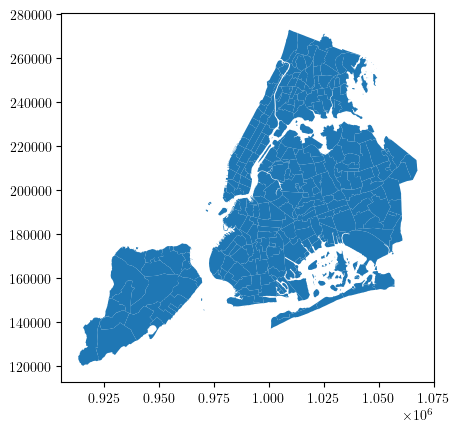

In [20]:
nyc_ntas.plot()

### NYC Census Block Groups (CBGs) 

<AxesSubplot: >

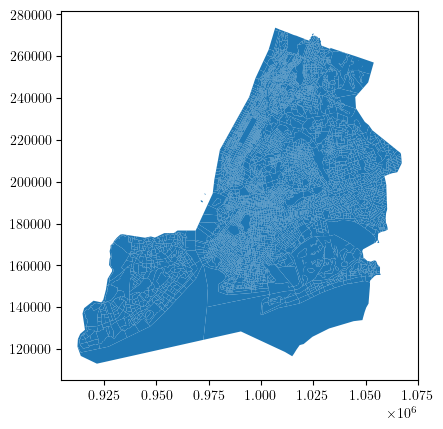

In [21]:
ny_cbgs = gpd.read_file('/share/pierson/nexar_data/5_other_datasets/tl_2020_36_all/tl_2020_36_bg20.shp')
ny_cbgs = ny_cbgs.to_crs(WGS)

nyc_cbgs = ny_cbgs[ny_cbgs.COUNTYFP20.isin(NYC_COUNTY_CODES)]
nyc_cbgs.reset_index(inplace=True)
nyc_cbgs = nyc_cbgs.to_crs(PROJ_CRS)
nyc_cbgs.GEOID20 = pd.to_numeric(nyc_cbgs.GEOID20)
nyc_cbgs.plot()

### NYC Zoning Data 

In [22]:
# Zoning Tests 
nyc_zoning = gpd.read_file("/share/pierson/nexar_data/5_other_datasets/nycgiszoningfeatures_202212shp")
nyc_zoning = nyc_zoning.to_crs('EPSG:2263')
def residential(z): 
    if 'R' in z:
        return True
    else:
        return False
    
def commercial(z): 
    if 'C' in z: 
        return True 
    else: 
        return False 

def manufacturing(z): 
    if 'M' in z:
        return True
    else: 
        return False 

def high_level_zoning(z): 
    if 'R' in z: 
        return 'R'
    elif 'C' in z:
        return 'C'
    elif 'M' in z:
        return 'M'
    
nyc_zoning['high_level_zone'] = nyc_zoning.ZONEDIST.map(lambda z: high_level_zoning(z))


nyc_zoning

,ZONEDIST,Shape_Leng,Shape_Area,geometry,high_level_zone
0,R4-1,2575.578630,3.722454e+05,"POLYGON ((982158.973 167972.613, 981835.726 16...",R
1,PARK,569.651123,1.606990e+04,"POLYGON ((996439.256 197691.699, 996350.793 19...",R
2,PARK,719.458367,2.017800e+04,"POLYGON ((988123.000 179762.232, 988060.069 17...",R
3,C4-4D,1147.584820,7.561834e+04,"POLYGON ((1013228.549 184395.280, 1013238.145 ...",C
4,PARK,465.328947,1.317632e+04,"POLYGON ((1003403.830 186973.910, 1003410.631 ...",R
...,...,...,...,...,...
5371,M1-1,4401.220026,1.120336e+06,"POLYGON ((1004792.801 213288.429, 1004618.608 ...",M
5372,M1-1,1566.373323,8.073075e+04,"POLYGON ((1006058.551 215036.152, 1005712.957 ...",M
5373,R7-2,3506.268529,5.547021e+05,"POLYGON ((1014785.988 176524.237, 1015806.342 ...",R
5374,R7-2,2053.239404,1.324074e+05,"POLYGON ((1011329.768 181024.901, 1011376.726 ...",R


### NYPD Precinct Locations 

In [23]:
precincts = pd.read_csv("/share/pierson/nexar_data/5_other_datasets/nypd_precinct_locs.csv")
precincts_gdf = gpd.GeoDataFrame(precincts, geometry=gpd.points_from_xy(precincts.lng, precincts.lat), crs=WGS)
precincts_gdf = precincts_gdf.to_crs(PROJ_CRS)

### NYC Borough Boundaries (NYBB) 

In [24]:
nybb = gpd.read_file(gpd.datasets.get_path('nybb'))
nybb = nybb.to_crs(PROJ_CRS)

### NYC Arrests Data 

In [25]:
nyc_arrests = pd.read_csv("/share/pierson/nexar_data/5_other_datasets/NYPD_Arrests_Data__Historic_.csv")

In [26]:
nyc_arrests = gpd.GeoDataFrame(nyc_arrests, geometry=gpd.points_from_xy(nyc_arrests.Longitude, nyc_arrests.Latitude), crs=WGS)
nyc_arrests = nyc_arrests.to_crs(PROJ_CRS)

In [27]:
arrests_by_nta = gpd.sjoin(nyc_arrests,nyc_ntas).groupby('NTAName').agg('size').to_frame('num_arrests')

In [28]:
nyc_ntas = nyc_ntas.merge(arrests_by_nta, left_on='NTAName', right_on='NTAName')

## 3. NYPD Deployment Analysis 

### Computing Probability Measures with Validation Set 

In [29]:
def calibrate_probabilities_using_valset(v, d_to_add_prediction_columns_to):
    """
    Annotate a dataframe, d_to_add_prediction_columns_to, with three prediction columns
    derived from the val set v.
    
    1. A simple binary variable with whether conf > POSITIVE_CLASSIFICATION_THRESHOLD
    2. A probabilistic prediction from val set: if above threshold, Pr(ground truth positive | above threshold in val set)
    and if below threshold, Pr(ground truth negative | below threshold in val set)
    3. A probability adjusted for police station distance. Not sure if this is a good thing to use, and should definitely check it is calibrated on test set if we do.
    """
    
    # 1. annotate with simple binary score
    assert v['Model_predicted_score'].isnull().sum() == 0
    v['classified_positive'] = v['Model_predicted_score'] > POSITIVE_CLASSIFICATION_THRESHOLD
    d_to_add_prediction_columns_to['above_threshold'] = (d_to_add_prediction_columns_to['conf'] > POSITIVE_CLASSIFICATION_THRESHOLD) * 1.
    
    # 2. compute probabilities given above/below threshold from val set
    p_positive_given_classified_positive = v.loc[v['classified_positive'] == True, 'ground_truth'].mean()
    p_positive_given_classified_negative = v.loc[v['classified_positive'] == False, 'ground_truth'].mean()
    print("Fraction of val set classified positive: %2.3f (%i rows)" % 
          (v['classified_positive'].mean(), v['classified_positive'].sum()))
    print("Pr(true positive | classified positive): %2.3f" % p_positive_given_classified_positive)
    print("Pr(true positive | classified negative): %2.3f" % p_positive_given_classified_negative)
    d_to_add_prediction_columns_to['calibrated_prediction'] = d_to_add_prediction_columns_to['above_threshold'].map(lambda x:p_positive_given_classified_positive if x == 1 else p_positive_given_classified_negative) 
    
    # 3. compute adjusted probability given police station distance. Not sure if this is necessary or wise, but adding just in case. 
    police_station_distance_model = sm.Logit.from_formula('ground_truth ~ Model_predicted_score + distance_from_nearest_police_station', data=v).fit()
    print(police_station_distance_model.summary())
    d_to_add_prediction_columns_to['Model_predicted_score'] = 0 # compute police-distance adjusted probability on d_to_add_prediction_columns_to. 
    d_to_add_prediction_columns_to.loc[~pd.isnull(d_to_add_prediction_columns_to['conf']), 'Model_predicted_score'] = d_to_add_prediction_columns_to['conf'].loc[~pd.isnull(d_to_add_prediction_columns_to['conf'])]
    assert d_to_add_prediction_columns_to['Model_predicted_score'].isnull().sum() == 0
    d_to_add_prediction_columns_to['prediction_adjusted_for_police_station_distance'] = police_station_distance_model.predict(d_to_add_prediction_columns_to).values
    del d_to_add_prediction_columns_to['Model_predicted_score']
    
    added_cols = ['above_threshold', 'calibrated_prediction', 'prediction_adjusted_for_police_station_distance']
    assert pd.isnull(d_to_add_prediction_columns_to[added_cols]).values.sum() == 0
    assert (d_to_add_prediction_columns_to[added_cols].values < 0).sum() == 0
    assert (d_to_add_prediction_columns_to[added_cols].values > 1).sum() == 0
    for col in added_cols:
        print("Mean value of prediction column %s: %2.3f; std %2.3f; > 0 %2.3f" % (
            col,
            d_to_add_prediction_columns_to[col].mean(), 
            d_to_add_prediction_columns_to[col].std(), 
            (d_to_add_prediction_columns_to[col] > 0).mean()))
    
    return d_to_add_prediction_columns_to
    
d_for_demo_analysis = calibrate_probabilities_using_valset(v=v, d_to_add_prediction_columns_to=d)


# PUT DGDF HERE 
# GeoDataFrame for d 
d_for_demo_analysis = gpd.GeoDataFrame(d_for_demo_analysis, geometry=gpd.points_from_xy(d_for_demo_analysis.lng, d_for_demo_analysis.lat), crs=WGS)
d_for_demo_analysis = d_for_demo_analysis.to_crs(PROJ_CRS)


Fraction of val set classified positive: 0.013 (264 rows)
Pr(true positive | classified positive): 0.777
Pr(true positive | classified negative): 0.002
Optimization terminated successfully.
         Current function value: 0.017459
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           ground_truth   No. Observations:                20000
Model:                          Logit   Df Residuals:                    19997
Method:                           MLE   Df Model:                            2
Date:                Sat, 29 Apr 2023   Pseudo R-squ.:                  0.7376
Time:                        18:48:27   Log-Likelihood:                -349.18
converged:                       True   LL-Null:                       -1330.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------

In [30]:
list(d_for_demo_analysis.columns)

['image_ref',
 'timestamp',
 'lat',
 'lng',
 'split',
 'conf',
 'has_prediction',
 'time_and_date_of_image',
 'hour',
 'day_of_week',
 'day_of_month',
 'month',
 'weekend',
 'phase',
 'nighttime',
 'geometry',
 'point_of_nearest_crime_1hr',
 'desc_of_nearest_crime_1hr',
 'time_of_nearest_crime_1hr',
 'distance_from_nearest_crime_1hr',
 'point_of_nearest_crime_3hr',
 'desc_of_nearest_crime_3hr',
 'time_of_nearest_crime_3hr',
 'distance_from_nearest_crime_3hr',
 'point_of_nearest_crime_6hr',
 'desc_of_nearest_crime_6hr',
 'time_of_nearest_crime_6hr',
 'distance_from_nearest_crime_6hr',
 'distance_from_nearest_police_station',
 'index_right',
 'index',
 'STATEFP20',
 'COUNTYFP20',
 'TRACTCE20',
 'BLKGRPCE20',
 'GEOID20',
 'NAMELSAD20',
 'MTFCC20',
 'FUNCSTAT20',
 'ALAND20',
 'AWATER20',
 'INTPTLAT20',
 'INTPTLON20',
 'NAME',
 'Estimate_Total',
 'MoE_Total',
 'Estimate_Total_Not_Hispanic_or_Latino',
 'MoE_Total_Not_Hispanic_or_Latino',
 'Estimate_Total_Not_Hispanic_or_Latino_White_alone',


### Geographic Aggregation 

In [31]:
pop_by_nta = d_for_demo_analysis.groupby(['ntaname','NAME'])[POPULATION_COUNT_COLS + 
                                                              DEMOGRAPHIC_COLS + 
                                                             PREDICTION_COLS].agg('first')[["Estimate_Total_Not_Hispanic_or_Latino_White_alone","Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone"]].groupby(level='ntaname').agg('sum')
pop_by_nta

est_by_nta = d_for_demo_analysis.groupby(['ntaname'])[PREDICTION_COLS].agg('mean')
est_by_nta

nta_grouped_d = pop_by_nta.join(est_by_nta)
nta_grouped_d = (nta_grouped_d, )


In [32]:
# group by Census area. 
grouped_d = d_for_demo_analysis.groupby(LOCATION_COL_TO_GROUP_ON)[POPULATION_COUNT_COLS + 
                                                              DEMOGRAPHIC_COLS + 
                                                              PREDICTION_COLS].agg('mean')
for col in POPULATION_COUNT_COLS + DEMOGRAPHIC_COLS: # check consistent values by location for demographics. Should only be one value of population count per Census area, for example. 
    if col in ['distance_from_nearest_crime_6hr', 'distance_from_nearest_police_station']:
        continue
    #assert d_for_demo_analysis.groupby(LOCATION_COL_TO_GROUP_ON)[col].nunique().map(lambda x:x in [0, 1]).all()

print("%i unique Census areas using column %s" % (len(grouped_d), LOCATION_COL_TO_GROUP_ON))
print("Population statistics by area")
print(grouped_d[TOTAL_POPULATION_COL].describe([0.01, 0.05, 0.1, 0.5, 0.9, 0.99]))
print("excluding census areas with population < %i keeps fraction %2.3f of population" % 
      (MIN_POPULATION_IN_AREA, 
       grouped_d.loc[grouped_d[TOTAL_POPULATION_COL] >= MIN_POPULATION_IN_AREA, TOTAL_POPULATION_COL].sum()/grouped_d[TOTAL_POPULATION_COL].sum()))
for col in POPULATION_COUNT_COLS: # sanity check that total counts look right. 
    print("summed values of %s: %i" % (col, grouped_d[col].sum()))
    

6522 unique Census areas using column GEOID20
Population statistics by area
count    6522.000000
mean     1276.103189
std       639.564257
min         0.000000
1%          0.000000
5%        389.150000
10%       588.000000
50%      1197.000000
90%      2091.900000
99%      3119.220000
max      8541.000000
Name: Estimate_Total, dtype: float64
excluding census areas with population < 500 keeps fraction 0.989 of population
summed values of Estimate_Total_Not_Hispanic_or_Latino_White_alone: 2646489
summed values of Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone: 1790337
summed values of Estimate_Total_Not_Hispanic_or_Latino_Asian_alone: 1177546
summed values of Estimate_Total_Hispanic_or_Latino: 2411452
summed values of Estimate_Total: 8322745


In [33]:
grouped_d.calibrated_prediction

GEOID20
3.600500e+11    0.002128
3.600500e+11    0.002128
3.600500e+11    0.002128
3.600500e+11    0.002128
3.600500e+11    0.002128
                  ...   
3.608503e+11    0.002128
3.608503e+11    0.002128
3.608503e+11    0.002128
3.608503e+11    0.002128
3.608503e+11    0.002128
Name: calibrated_prediction, Length: 6522, dtype: float64

In [34]:
len(nyc_cbgs.index)

6807

### Disparities Estimator 

In [35]:
for prediction_col in PREDICTION_COLS:
    print("Using prediction col", prediction_col)
    estimates = {}
    for demo_col in POPULATION_COUNT_COLS:
        if demo_col == TOTAL_POPULATION_COL:
            continue
        # compute weighted mean as described in Census tract. 
        grouped_mean = (grouped_d[prediction_col] * grouped_d[demo_col]).sum()/grouped_d[demo_col].sum()
        print(demo_col, grouped_mean)
        estimates[demo_col] = grouped_mean
    print("Ratio of Black estimate to white estimate: %2.3f" % (estimates[BLACK_POPULATION_COL]/estimates[WHITE_POPULATION_COL]))

Using prediction col above_threshold
Estimate_Total_Not_Hispanic_or_Latino_White_alone 0.010791310613795771
Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone 0.011326153942569438
Estimate_Total_Not_Hispanic_or_Latino_Asian_alone 0.009374994031214858
Estimate_Total_Hispanic_or_Latino 0.011149681700477448
Ratio of Black estimate to white estimate: 1.050
Using prediction col calibrated_prediction
Estimate_Total_Not_Hispanic_or_Latino_White_alone 0.010484742106038012
Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone 0.010898917859350937
Estimate_Total_Not_Hispanic_or_Latino_Asian_alone 0.009387964870608981
Estimate_Total_Hispanic_or_Latino 0.01076226003849925
Ratio of Black estimate to white estimate: 1.040
Using prediction col prediction_adjusted_for_police_station_distance
Estimate_Total_Not_Hispanic_or_Latino_White_alone 0.00965519530912918
Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone 0.010009954768642453
Estimate_Total_No

## 4. Analysis Plots 

### Correlations Between All Measures 

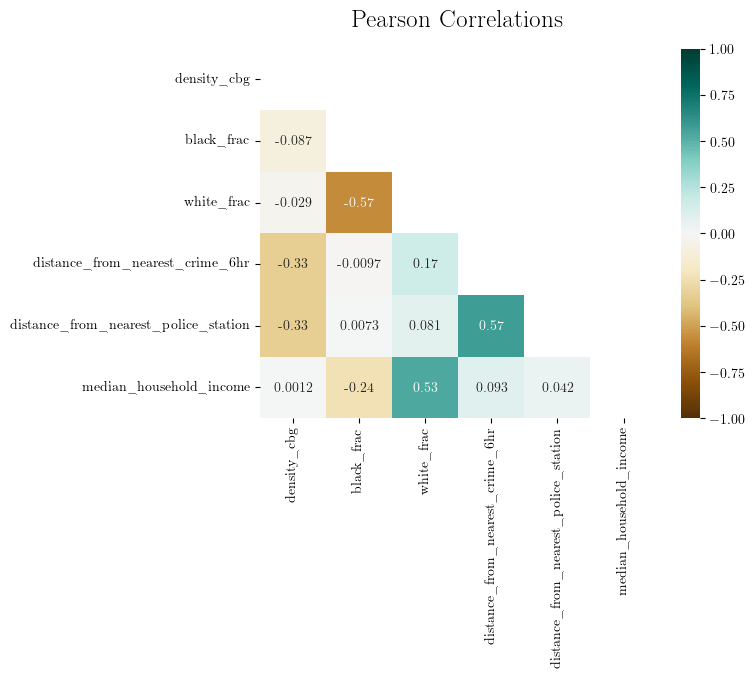

In [36]:
# Pearson Correlation Coefficient
pearson_corr = grouped_d.loc[grouped_d[TOTAL_POPULATION_COL] > MIN_POPULATION_IN_AREA, DEMOGRAPHIC_COLS].corr(method='pearson')
mask = np.triu(np.ones_like(pearson_corr, dtype=bool))
heatmap = sns.heatmap(pearson_corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Pearson Correlations', fontdict={'fontsize':18}, pad=16);

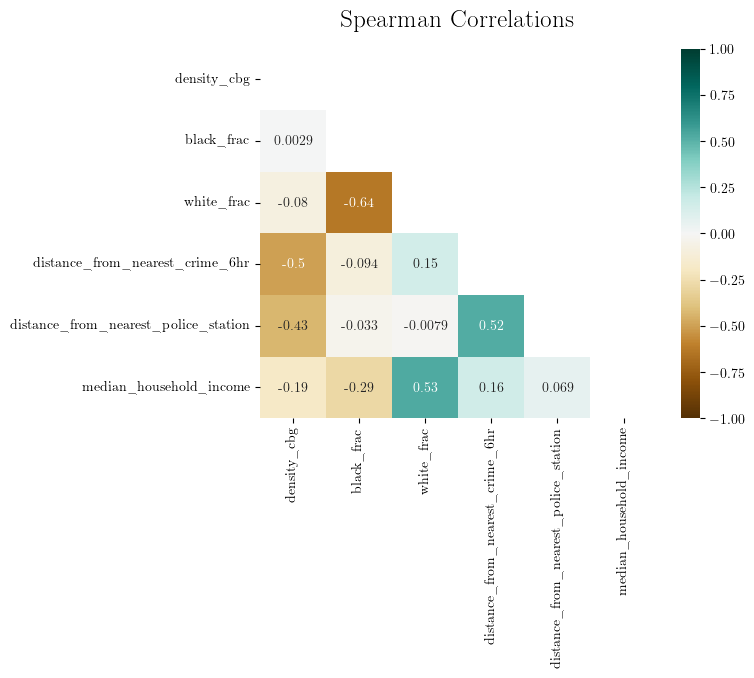

In [37]:
# Spearman Correlation Coefficient
spearman_corr = grouped_d.loc[grouped_d[TOTAL_POPULATION_COL] > MIN_POPULATION_IN_AREA, DEMOGRAPHIC_COLS].corr(method='spearman')
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))
heatmap = sns.heatmap(spearman_corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Spearman Correlations', fontdict={'fontsize':18}, pad=16);

### Breakdown by Neighborhood 

In [38]:
for col in PREDICTION_COLS:
    print("\n\nneighborhoods with highest mean values of %s" % col)
    print(d_for_demo_analysis
          .groupby(NEIGHBORHOOD_COL)[col]
          .agg(['mean', 'size'])
          .reset_index()
          .sort_values(by='mean')[::-1])
nta_breakdown = d_for_demo_analysis.groupby(NEIGHBORHOOD_COL)['calibrated_prediction'].agg(['mean', 'size']).reset_index().sort_values(by='mean')[::-1]



neighborhoods with highest mean values of above_threshold
                                          ntaname      mean  size
94                                       Gramercy  0.062644  2602
158         Mount Hebron & Cedar Grove Cemeteries  0.058824    17
229                          Tribeca-Civic Center  0.053404  4157
212                       St. George-New Brighton  0.049180   244
199               SoHo-Little Italy-Hudson Square  0.045702  5689
..                                            ...       ...   ...
120  Jacob Riis Park-Fort Tilden-Breezy Point Tip  0.000000    11
167                  Oakland Gardens-Hollis Hills  0.000000   259
118                              Inwood Hill Park  0.000000    69
160          Mount Olivet & All Faiths Cemeteries  0.000000    82
133                          Lincoln Terrace Park  0.000000   136

[256 rows x 3 columns]


neighborhoods with highest mean values of calibrated_prediction
                                          ntaname      mea

## Map of Pr(police) by Census area (either neighborhood or Census tract). Can show this next to maps of density and potentially other variables - we decided to make this by neighborhood for a number of reasons. 

### Plot Data Loaded from Bootstraps 

In [39]:
import json
nta_data = json.load(open("/share/pierson/nexar_data/bootstraps_for_matt/neighborhood_bootstraps.json"))

In [40]:
nta_rta_means = pd.DataFrame.from_dict(nta_data['point_estimate'], orient='index')
nta_rta_means = nta_rta_means[nta_rta_means.index.map(lambda x: 'relative_to_average' in x)]
nta_rta_means.index = nta_rta_means.index.str.replace('_relative_to_average','')
nta_rta_means.columns = ['Pr_police_rta']
nta_rta_means

,Pr_police_rta
Allerton,0.662275
Alley Pond Park,0.332972
Annadale-Huguenot-Prince's Bay-Woodrow,0.336225
Arden Heights-Rossville,0.221169
Astoria (Central),1.041685
...,...
Williamsbridge-Olinville,0.775639
Williamsburg,1.069024
Windsor Terrace-South Slope,0.418560
Woodhaven,0.454698


In [41]:
nyc_ntas = nyc_ntas.merge(nta_rta_means, left_on='NTAName', right_index=True, how='left')

In [42]:
bins = [0, 0.25, 0.5, 0.75, 1, 2, 3,  4, 5]
#labels = ['( 0, 0.5 ]', '( 0.5, 1 ]', '( 1, 2 ]', '> 2']
nyc_ntas['Pr_police_rta'].fillna(0, inplace=True)
nyc_ntas['pr_quantile'] = pd.cut(nyc_ntas['Pr_police_rta'], bins)

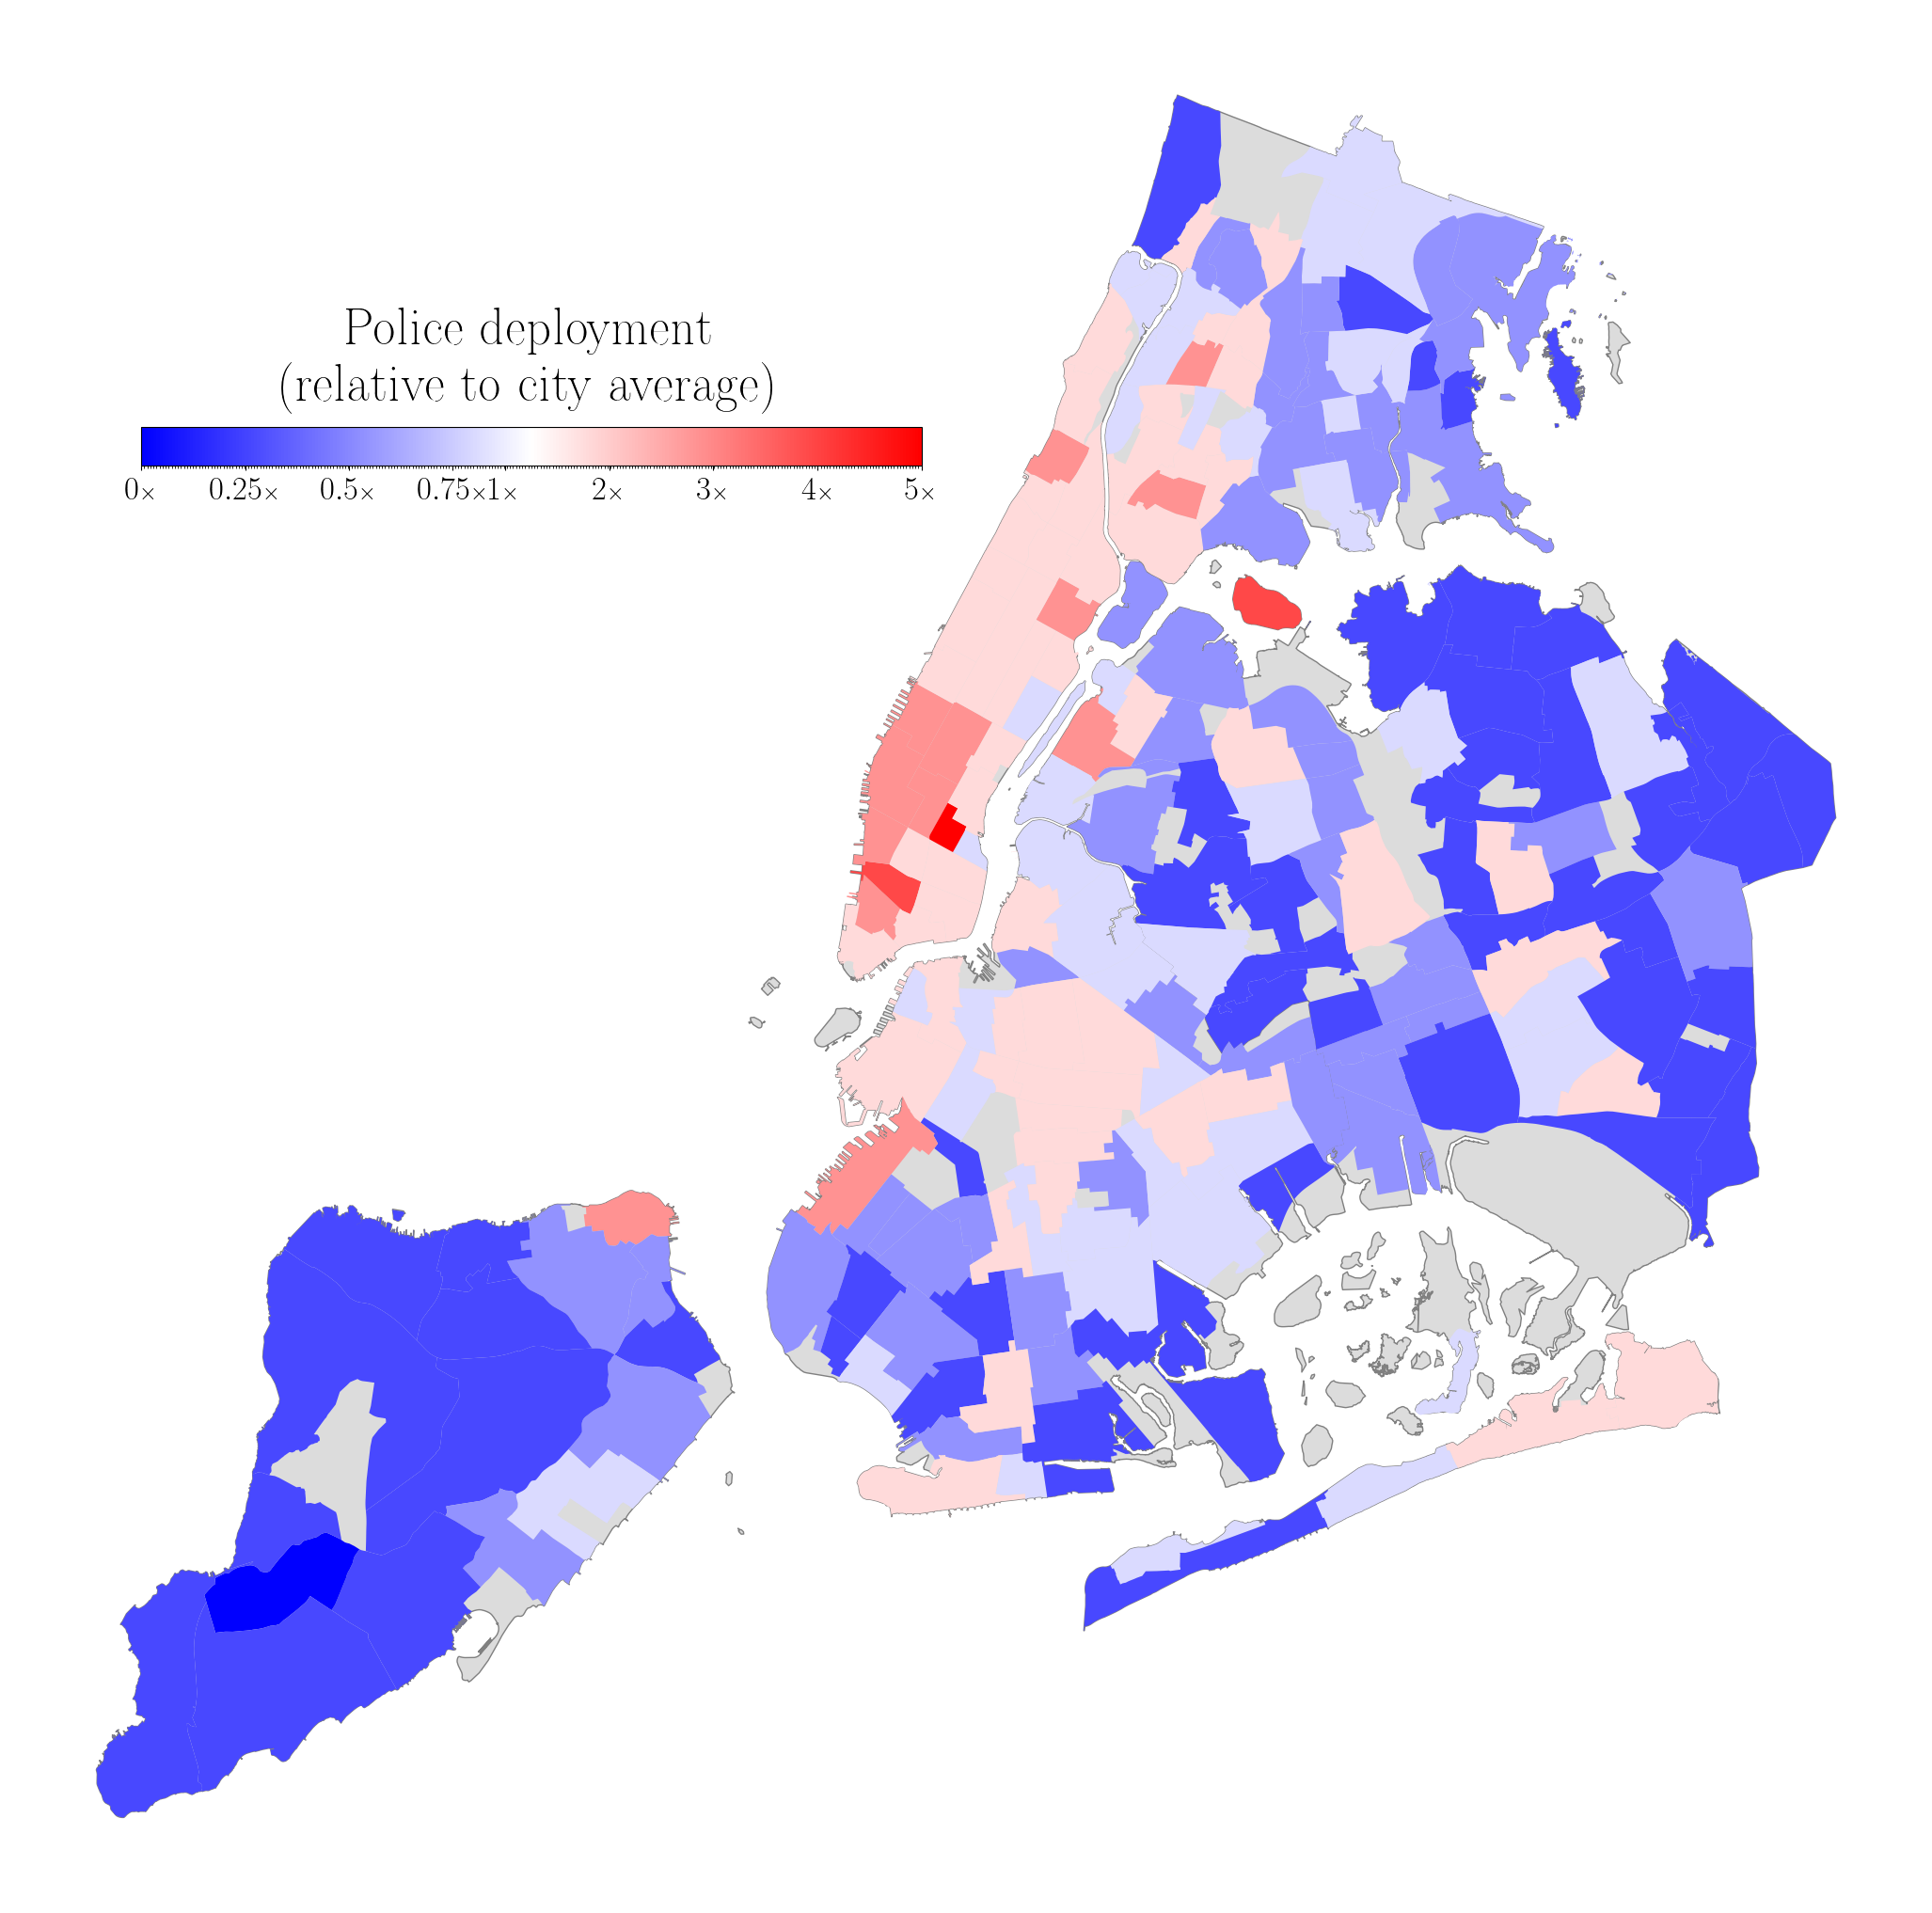

In [44]:
fig, ax = plt.subplots(figsize=(24,24))
colormap = 'bwr'
nybb.plot(ax=ax, color='gainsboro', edgecolor='grey')
nyc_ntas.plot(column='pr_quantile', ax=ax, cmap=colormap, legend=False)#, legend_kwds={'loc': 'upper left', 'title': 'Police deployment\n(relative to city average)', 'ncols':2, 'fontsize':50, 'markerscale':3, 'title_fontsize':60, 'alignment':'center'})

n = 16 # how many lines to draw or number of discrete color levels

cmap = plt.get_cmap(colormap)

norm = matplotlib.colors.Normalize(vmin=0, vmax=5)
stretched_bounds = np.interp(np.linspace(0, 1, 257), np.linspace(0, 1, 16), [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
# normalize stretched bound values
norm = matplotlib.colors.BoundaryNorm(stretched_bounds, ncolors=256)
scalarmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#sm.set_array([])
cb = plt.colorbar(scalarmap, ticks=np.arange(0,n), ax=ax, orientation='horizontal', ticklocation='bottom', pad=0, anchor=(0.2,6), shrink=0.35)
cb.ax.xaxis.set_label_position('top')
cb.set_label(label='Police deployment\n(relative to city average)',size=40,weight='bold', labelpad=20)
cb.set_ticks([0, 0.25, 0.5, 0.75, 1, 2, 3,  4, 5], labels=[r'${0\scriptstyle\times}$', r'${0.25\scriptstyle\times}$', r'${0.5\scriptstyle\times}$', r'${0.75\scriptstyle\times}$', r'${1\scriptstyle\times}$', r'${2\scriptstyle\times}$', r'${3\scriptstyle\times}$', r'${4\scriptstyle\times}$', r'${5\scriptstyle\times}$'],size=25)


plt.axis('off')
plt.tight_layout()
plt.savefig(f'{PAPER_GIT_REPO_PATH}/figures/Pr_police_rta_ntas.pdf')


### VARIANT: Un-bootstrapped Data 

"['index_left'] not found in axis"


/share/pierson/conda_virtualenvs/fpp_geospatial/lib/python3.11/site-packages/geopandas/geodataframe.py:202: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)


count    235.000000
mean       0.010174
std        0.007753
min        0.000000
25%        0.004649
50%        0.008210
75%        0.013572
max        0.051994
Name: calibrated_prediction, dtype: float64


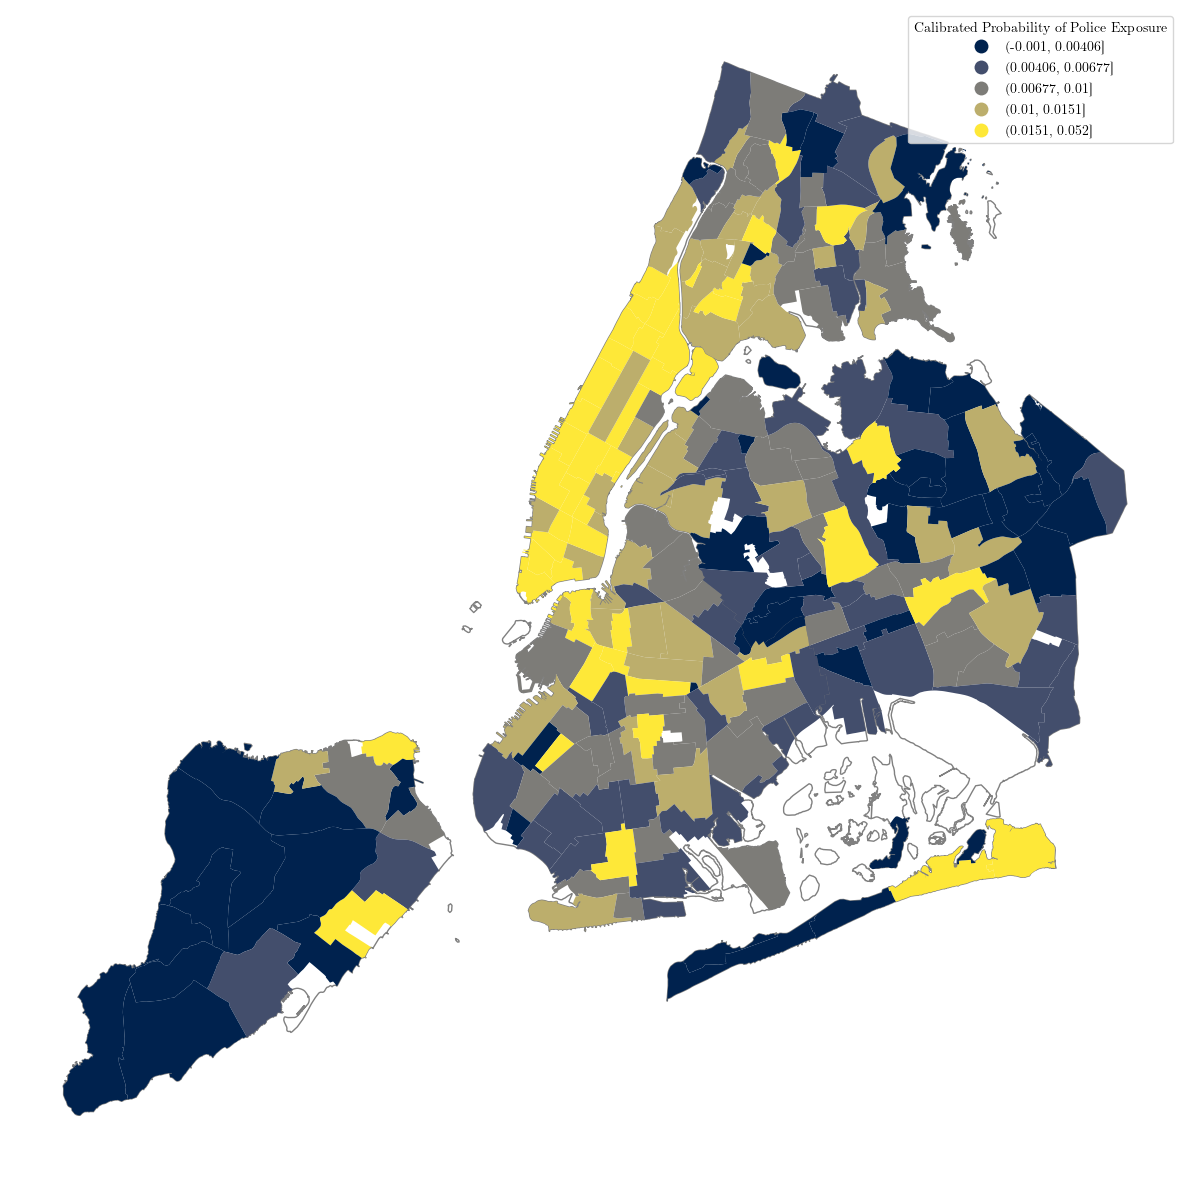

In [45]:
fig, ax = plt.subplots(figsize=(12,12))

try: 
    d_for_demo_analysis.drop(['index_right'],axis=1,inplace=True)

except Exception as e:
    print(e)
    pass 


try: 
    d_for_demo_analysis.drop(['index'],axis=1,inplace=True)

except Exception as e:
    print(e)
     

try: 
    d_for_demo_analysis.drop(['index_left'],axis=1,inplace=True)

except Exception as e:
    print(e)


dgdf_for_demo_by_ntas = gpd.sjoin(nyc_ntas, d_for_demo_analysis, how='left', predicate='contains').groupby('NTAName').agg('mean','size')

nyc_ntas_proj_demo = nyc_ntas.merge(dgdf_for_demo_by_ntas,left_on='NTAName',right_on='NTAName')
nyc_ntas_proj_demo.calibrated_prediction.fillna(0, inplace=True)
nyc_ntas_proj_demo.calibrated_prediction_decile = pd.qcut(nyc_ntas_proj_demo.calibrated_prediction, 5, duplicates='drop')
print(nyc_ntas_proj_demo.calibrated_prediction.describe())



nybb.plot(ax=ax, edgecolor='grey', color='w')
nyc_ntas_proj_demo.plot(column=nyc_ntas_proj_demo.calibrated_prediction_decile, ax=ax, cmap='cividis', legend=True, legend_kwds={'title':'Calibrated Probability of Police Exposure'})


#nyc_ntas.plot(color='blue', ax=ax)

#nyc_ntas.merge(nta_grouped_d, left_on='NTAName', right_on='ntaname').fillna(0).plot(column='calibrated_prediction', ax=ax, cmap='plasma', legend=True, legend_kwds={"location": "bottom", "shrink": 0.5, "pad": 0, 'label': 'Calibrated Probability of Police Exposure'})




plt.axis('off')
plt.tight_layout()
#plt.savefig(f"{PAPER_GIT_REPO_PATH}/figures/Pr_police_by_nta.jpg", dpi=450)


### VARIANT2: More granular, exposure by CBG 

In [46]:
dgdf_for_demo_by_cbgs = gpd.sjoin(nyc_cbgs, d_for_demo_analysis, how='left', predicate='contains').groupby('index').agg('mean')


/tmp/ipykernel_2788316/1317250511.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dgdf_for_demo_by_cbgs = gpd.sjoin(nyc_cbgs, d_for_demo_analysis, how='left', predicate='contains').groupby('index').agg('mean')


/share/pierson/conda_virtualenvs/fpp_geospatial/lib/python3.11/site-packages/geopandas/geodataframe.py:202: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)


0         (0.0105, 0.016]
1       (0.00402, 0.0105]
2         (0.016, 0.0239]
3         (0.0105, 0.016]
4         (0.0105, 0.016]
              ...        
6802      (0.0105, 0.016]
6803      (0.016, 0.0239]
6804       (0.039, 0.518]
6805      (0.0239, 0.039]
6806      (0.0105, 0.016]
Name: calibrated_prediction, Length: 6807, dtype: category
Categories (7, interval[float64, right]): [(-0.001, 0.00213] < (0.00213, 0.00402] < (0.00402, 0.0105] < (0.0105, 0.016] < (0.016, 0.0239] < (0.0239, 0.039] < (0.039, 0.518]]


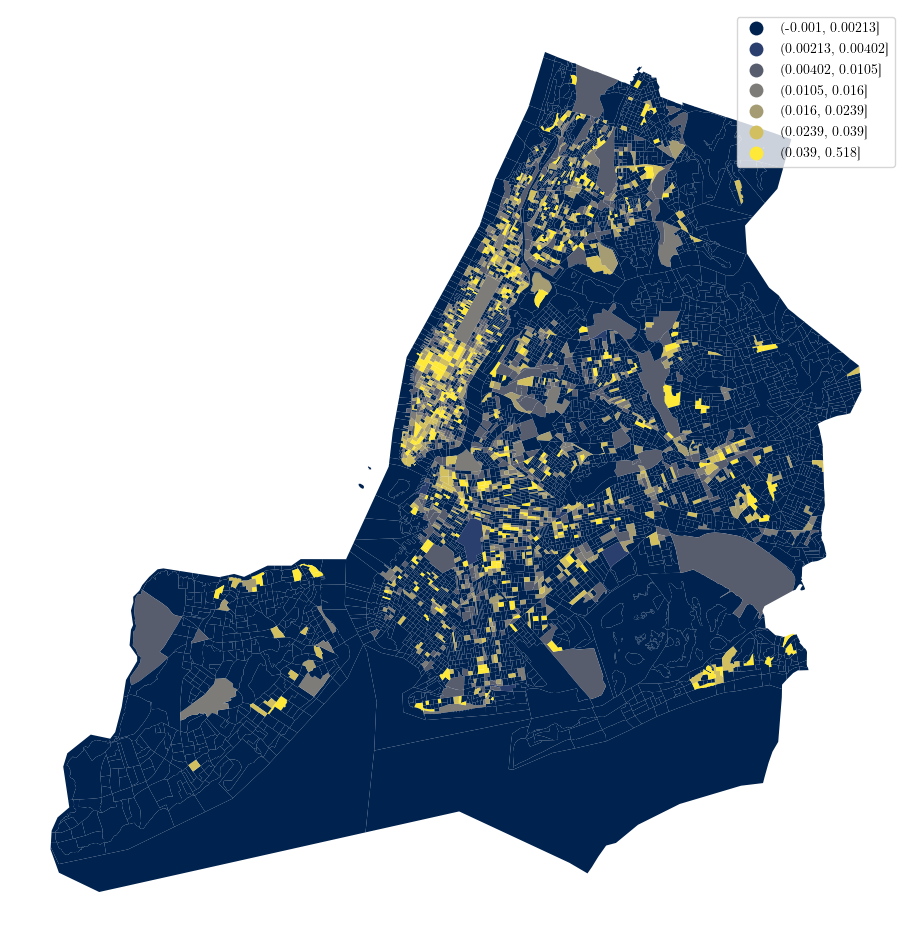

In [47]:
fig, ax = plt.subplots(figsize=(12,12))

nyc_cbgs_proj_demo = nyc_cbgs.merge(dgdf_for_demo_by_cbgs,left_on='GEOID20',right_on='GEOID20_left')
nyc_cbgs_proj_demo.calibrated_prediction.fillna(0, inplace=True)
nyc_cbgs_proj_demo.calibrated_prediction_decile = pd.qcut(nyc_cbgs_proj_demo.calibrated_prediction, 18, duplicates='drop')
print(nyc_cbgs_proj_demo.calibrated_prediction_decile)
nyc_cbgs_proj_demo.plot(column=nyc_cbgs_proj_demo.calibrated_prediction_decile, ax=ax, cmap='cividis', legend=True)#,legend_kwds={"location": "bottom", "shrink": 0.5, "pad": 0, 'label': 'Calibrated Probability of Police Exposure'})

plt.axis('off')

plt.savefig('PR_police_by_cbg.jpg', dpi=450)

### Table of neighborhoods with highest police levels  (include borough as a column as well assuming that each neighborhood is only in one borough). 

In [49]:
print(nyc_cbgs_proj_demo['Estimate_Total'].sum())

nta_breakdown_top10 = nyc_ntas_proj_demo.sort_values(by='calibrated_prediction')[::-1][:10][["NTAName", "BoroName", "calibrated_prediction"]]

rename = {"NTAName": "Neighborhood", "BoroName": "Borough", "calibrated_prediction": "Calibrated Probability of Police Exposure"}

nta_breakdown_top10.rename(columns=rename, inplace=True)

nta_breakdown_top10.to_latex(f'{PAPER_GIT_REPO_PATH}/tables/nta_breakdown_top10.tex', index=False, float_format="%.2f")

nta_breakdown_top10

8322745.0


/tmp/ipykernel_2788316/4029585587.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  nta_breakdown_top10.to_latex(f'{PAPER_GIT_REPO_PATH}/tables/nta_breakdown_top10.tex', index=False, float_format="%.2f")


,Neighborhood,Borough,Calibrated Probability of Police Exposure
120,Gramercy,Manhattan,0.051994
108,Tribeca-Civic Center,Manhattan,0.044208
217,St. George-New Brighton,Staten Island,0.039903
109,SoHo-Little Italy-Hudson Square,Manhattan,0.037408
118,Midtown-Times Square,Manhattan,0.029508
210,Rockaway Beach-Arverne-Edgemere,Queens,0.026843
115,Chelsea-Hudson Yards,Manhattan,0.026633
114,East Village,Manhattan,0.026494
117,Midtown South-Flatiron-Union Square,Manhattan,0.026328
225,New Dorp-Midland Beach,Staten Island,0.025393


### Table of police levels by borough (currently this is showing big disparities for Manhattan)

In [50]:
boro_breakdown = d_for_demo_analysis.groupby('boroname')['calibrated_prediction'].agg(['mean']).sort_values(by='mean')[::-1]

boro_populations = nyc_cbgs_proj_demo.groupby('borocode')['Estimate_Total'].agg('sum')

boro_populations.index = boro_breakdown.index


cols=['calibrated_prediction_mean', 'calibrated_prediction_size', 'calibrated_prediction_sum', 'total_population_mean', 'total_population_size', 'total_population_sum']

rename = {"mean": "Calibrated Probability of Police Exposure", "Index": "Borough"}
boro_breakdown = boro_breakdown.rename(columns=rename)
#boro_breakdown.columns=boro_breakdown.columns.droplevel(0) 
#boro_breakdown.columns = cols

boro_breakdown['Total Population'] = boro_populations
boro_breakdown = boro_breakdown.rename_axis('Borough')


boro_breakdown['Population Weighted Probability of Police'] = (boro_breakdown['Calibrated Probability of Police Exposure'] * boro_breakdown['Total Population']) / boro_breakdown['Total Population'].sum() 
boro_breakdown['Population Weighted Probability of Police, Relative to Mean'] = boro_breakdown['Population Weighted Probability of Police'] / boro_breakdown['Population Weighted Probability of Police'].mean()

boro_breakdown = boro_breakdown['Population Weighted Probability of Police, Relative to Mean']
boro_breakdown.to_latex(f'{PAPER_GIT_REPO_PATH}/tables/borough_breakdown.tex', index=True, float_format="%.2f")    

boro_breakdown


/tmp/ipykernel_2788316/3766662181.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  boro_breakdown.to_latex(f'{PAPER_GIT_REPO_PATH}/tables/borough_breakdown.tex', index=True, float_format="%.2f")


Borough
Manhattan        1.757131
Bronx            0.760706
Brooklyn         1.372146
Queens           0.931106
Staten Island    0.178910
Name: Population Weighted Probability of Police, Relative to Mean, dtype: float64

### Police levels by zone (residential vs commercial etc). 

In [51]:
nyc_zoning_demo = gpd.overlay(nyc_cbgs_proj_demo, nyc_zoning, how='intersection')

<AxesSubplot: >

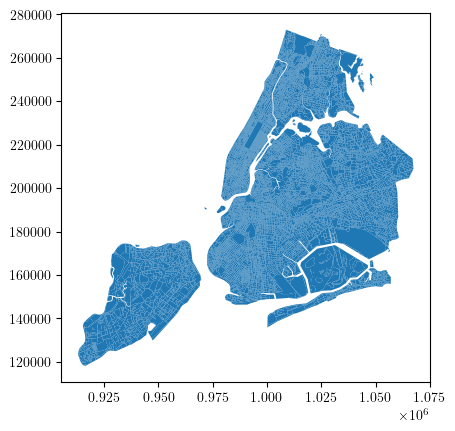

In [52]:
nyc_zoning_demo.plot()

In [53]:
nyc_cbgs_proj_demo.geometry.area.describe()

count    6.807000e+03
mean     1.934858e+06
std      2.101230e+07
min      1.265780e+03
25%      4.134625e+05
50%      6.797400e+05
75%      1.258155e+06
max      1.407942e+09
dtype: float64

In [54]:
nyc_cbgs_proj_demo.groupby('GEOID20').agg('first')["shape_area"].describe()

count    6.495000e+03
mean     3.413199e+06
std      5.542251e+06
min      4.005503e+05
25%      1.687712e+06
50%      2.001449e+06
75%      3.051827e+06
max      1.971899e+08
Name: shape_area, dtype: float64

In [55]:
nyc_zoning_demo['subarea'] = nyc_zoning_demo.geometry.area
nyc_zoning_demo.subarea.describe()

count    2.569600e+04
mean     3.569553e+05
std      2.123846e+06
min      4.542494e-06
25%      4.479878e+03
50%      1.006384e+05
75%      3.279648e+05
max      1.954145e+08
Name: subarea, dtype: float64

<AxesSubplot: >

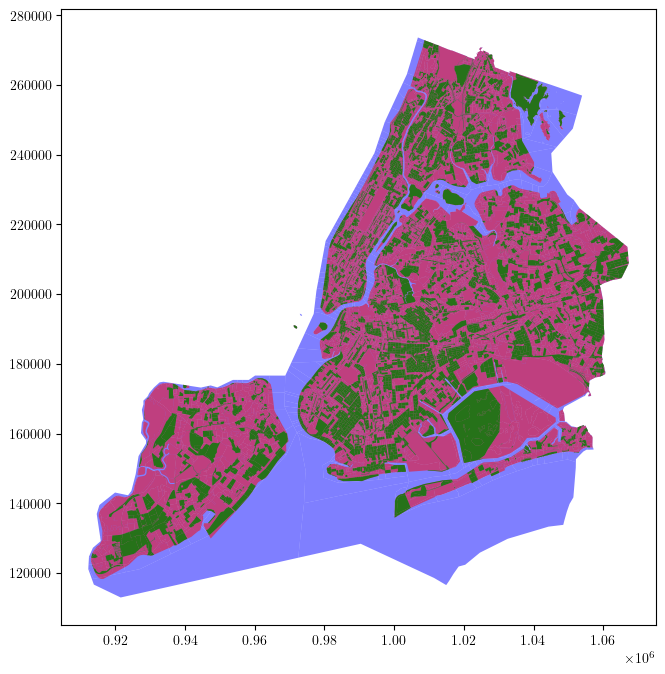

In [56]:
fig, ax = plt.subplots(figsize=(8,8))
nyc_cbgs_proj_demo.plot(ax=ax, color='blue', alpha=0.5)
nyc_zoning_demo.plot(ax=ax, color='red', alpha=0.5)
nyc_zoning_demo.groupby('GEOID20').agg('first').plot(ax=ax, color='green', alpha=0.8)

In [57]:
nyc_zoning_demo.groupby('GEOID20').agg('first').geometry.area.describe()

count    6.806000e+03
mean     4.814087e+05
std      2.505174e+06
min      4.703533e-06
25%      4.333597e+04
50%      2.187981e+05
75%      5.030440e+05
max      1.713857e+08
dtype: float64

In [58]:
cbgs_by_zone_prop = nyc_zoning_demo.groupby(['GEOID20','high_level_zone'])["subarea"].agg('sum').unstack(level=1).fillna(0).div(nyc_cbgs_proj_demo.set_index('GEOID20').geometry.area, axis='rows') 
cbgs_by_zone_prop
residential_cbgs = cbgs_by_zone_prop[cbgs_by_zone_prop.R > 0.9]
commercial_cbgs = cbgs_by_zone_prop[cbgs_by_zone_prop.C > 0.9]
manufacturing_cbgs = cbgs_by_zone_prop[cbgs_by_zone_prop.M > 0.9]


print(commercial_cbgs)
print(manufacturing_cbgs)

high_level_zone         C         M         R
GEOID20                                      
360050001001     0.993296  0.000000  0.000000
360050019042     0.980276  0.000000  0.000000
360050061001     0.974966  0.000000  0.025034
360050119001     0.914884  0.001348  0.083768
360050212001     0.986003  0.000000  0.013997
...                   ...       ...       ...
360810446012     0.999451  0.000549  0.000000
360810455006     0.999588  0.000000  0.000412
360810871001     0.974218  0.006978  0.001135
360850128063     0.992932  0.000000  0.007068
360850277022     0.961812  0.000000  0.038188

[181 rows x 3 columns]
high_level_zone             C         M         R
GEOID20                                          
360050019031     0.000000e+00  1.000000  0.000000
360050019032     1.276265e-08  0.987138  0.012862
360050019041     0.000000e+00  1.000000  0.000000
360050060001     5.408122e-03  0.962986  0.031606
360050093015     1.792340e-02  0.981883  0.000194
...                       ..

In [59]:
residential_grouped_d = grouped_d[grouped_d.index.isin(residential_cbgs.index)]
commercial_grouped_d = grouped_d[grouped_d.index.isin(commercial_cbgs.index)]
manufacturing_grouped_d = grouped_d[grouped_d.index.isin(manufacturing_cbgs.index)]


In [60]:
print(d_for_demo_analysis.columns)
#dgdf_for_demo_analysis.drop('index_right', axis=1, inplace=True)
d_mapped_to_zones = gpd.sjoin(nyc_zoning, d_for_demo_analysis)


Index(['image_ref', 'timestamp', 'lat', 'lng', 'split', 'conf',
       'has_prediction', 'time_and_date_of_image', 'hour', 'day_of_week',
       ...
       'ANH_20P', 'ONH_20P', 'NH2pl_20P', 'density_tract', 'white_frac',
       'black_frac', 'date', 'above_threshold', 'calibrated_prediction',
       'prediction_adjusted_for_police_station_distance'],
      dtype='object', length=118)


In [61]:
pr_by_zone = d_mapped_to_zones.groupby('ZONEDIST').agg('mean','size')[['calibrated_prediction','density_cbg']].sort_values(by='calibrated_prediction')[::-1]
pr_by_zone.index.values
m = [x for x in pr_by_zone.index.values if 'M' in x]
c = [x for x in pr_by_zone.index.values if 'C' in x]
r = [x for x in pr_by_zone.index.values if 'R' in x]
# r also picks up 'PARK' and 'PLAYGROUND' which is a convenient catch in my mind 
print(m)
print(c)
print(r)

m_pr = pr_by_zone[pr_by_zone.index.isin(m)]
c_pr = pr_by_zone[pr_by_zone.index.isin(c)]
r_pr = pr_by_zone[pr_by_zone.index.isin(r)]



def zone_classifier(z): 
    if 'R' in z: 
        return 'R'
    elif 'C' in z:
        return 'C'
    elif 'M' in z:
        return 'M'

print(m_pr.agg('mean'), c_pr.agg('mean'), r_pr.agg('mean'))
print(c_pr.agg('mean') / r_pr.agg('mean'))

pr_by_zone['type'] = pr_by_zone.index.map(lambda x: zone_classifier(x))
pr_by_zone

['M1-5/R7-2', 'M1-3/R7X', 'C6-4M', 'M1-5/R10', 'M1-4/R9', 'M1-5/R9X', 'M1-6', 'M1-5/R7D', 'M1-1D', 'M1-5/R9A', 'M1-4/R6B', 'M2-3', 'M1-4', 'M1-6/R10', 'M1-3/R8', 'M1-5', 'M2-4', 'M1-4/R8A', 'M1-5/R9', 'M1-3', 'M1-4/R7A', 'M3-2', 'M1-4D', 'M1-5/R7X', 'M2-1', 'M1-2D', 'M1-1', 'M1-1/R7-2', 'M1-2/R6A', 'M1-5/R7-3', 'M1-2', 'M1-2/R6B', 'M3-1', 'M1-2/R6', 'M1-2/R8A', 'M1-4/R9A', 'M1-5/R6A', 'M1-5/R9-1', 'M1-4/R6A', 'M1-6/R8X', 'M1-5B', 'M1-5M', 'M1-4/R7X', 'M1-4/R7D', 'M1-4/R7-3', 'M1-4/R7-2', 'M1-6D', 'M1-2/R8', 'M1-1/R5', 'M1-1/R6A', 'M1-5/R8A', 'C6-2M', 'M1-1/R7D', 'M1-2/R7A', 'M2-2', 'M1-2/R5B', 'M1-2/R5D', 'M1-6/R9', 'M1-2/R7-2']
['C6-1G', 'C1-9A', 'C6-7T', 'C4-6', 'C1-7A', 'C6-4.5', 'C5-2A', 'C6-7', 'C6-4X', 'C1-8A', 'C6-4M', 'C6-4', 'C6-1', 'C6-2A', 'C6-6', 'C4-2F', 'C6-3', 'C5-5', 'C5-2.5', 'C1-8', 'C5-4', 'C5-3', 'C2-8A', 'C4-4L', 'C4-7', 'C6-2', 'C7', 'C6-3X', 'C6-2G', 'C5-2', 'C8-2', 'C4-5X', 'C4-4', 'C1-9', 'C8-3', 'C1-6', 'C6-9', 'C4-4D', 'C8-1', 'C6-3A', 'BPC', 'C6-3D', 'C1-8X'

,calibrated_prediction,density_cbg,type
ZONEDIST,,,
M1-5/R7-2,0.249273,36363.272102,R
R9X,0.136526,57555.240474,R
C6-1G,0.114704,76689.129690,C
C1-9A,0.059327,126286.147466,C
C6-7T,0.054452,22061.324668,C
...,...,...,...
M1-2/R5B,0.002128,20045.022417,R
C4-5A,0.002128,88359.728700,C
M1-2/R5D,0.002128,13627.135889,R


In [62]:


def population_weighting(metric_to_weight, weights):
    return (metric_to_weight * weights).sum() / weights.sum()

#r_pr = ((residential_grouped_d.calibrated_prediction * residential_grouped_d['Estimate_Total:'])).sum() / r_pop
#c_pr = (commercial_grouped_d.calibrated_prediction * (commercial_grouped_d['Estimate_Total:'] / c_pop)).mean()
#m_pr = (manufacturing_grouped_d.calibrated_prediction * (manufacturing_grouped_d['Estimate_Total:'] / m_pop)).mean()

r_pr = population_weighting(residential_grouped_d.calibrated_prediction, residential_grouped_d['Estimate_Total'])
c_pr = population_weighting(commercial_grouped_d.calibrated_prediction, commercial_grouped_d['Estimate_Total'])
m_pr = population_weighting(manufacturing_grouped_d.calibrated_prediction, manufacturing_grouped_d['Estimate_Total'])

#r_pr = residential_grouped_d.calibrated_prediction.mean()
#c_pr = commercial_grouped_d.calibrated_prediction.mean()
#m_pr = manufacturing_grouped_d.calibrated_prediction.mean()

data = {'Residential': r_pr, 'Commercial': c_pr, 'Manufacturing': m_pr}
print(data)
pr_by_zone_table = pd.DataFrame.from_dict(data, orient='index')

pr_by_zone_table = pr_by_zone_table.rename_axis('Zoning Type')
pr_by_zone_table.columns = ['Population-Weighted Probability of Police Exposure']


#pr_by_zone_table.to_latex(f'{PAPER_GIT_REPO_PATH}/tables/pr_by_zone_type.tex', float_format="%.2f")

pr_by_zone_table





{'Residential': 0.00911971901504352, 'Commercial': 0.02236631530475879, 'Manufacturing': 0.008490593433341987}


,Population-Weighted Probability of Police Exposure
Zoning Type,
Residential,0.009120
Commercial,0.022366
Manufacturing,0.008491


### Police levels by race 

In [63]:
for prediction_col in PREDICTION_COLS:
    print("Using prediction col", prediction_col)
    estimates = {}
    for demo_col in POPULATION_COUNT_COLS:
        if demo_col == TOTAL_POPULATION_COL:
            continue
        # compute weighted mean as described in Census tract. 
        grouped_mean = (grouped_d[prediction_col] * grouped_d[demo_col]).sum()/grouped_d[demo_col].sum()
        print(demo_col, grouped_mean)
        estimates[demo_col] = grouped_mean
    print("Ratio of Black estimate to white estimate: %2.3f" % (estimates[BLACK_POPULATION_COL]/estimates[WHITE_POPULATION_COL]))


pr_by_race_table = pd.DataFrame.from_dict(estimates, orient='index')
pr_by_race_table['Weighted Probability of Police, Relative to Mean'] = pr_by_race_table.iloc[:,0] / pr_by_race_table.iloc[:,0].mean()

nice_names = {'Estimate_Total_Not_Hispanic_or_Latino_White_alone': 'White', 'Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone': 'Black/African American', 'Estimate_Total_Not_Hispanic_or_Latino_Asian_alone': 'Asian', 'Estimate_Total_Hispanic_or_Latino': 'Hispanic / Some other race'}
pr_by_race_table.index = pr_by_race_table.index.map(lambda x: nice_names[x])
pr_by_race_table = pr_by_race_table['Weighted Probability of Police, Relative to Mean']



pr_by_race_table.to_latex(f'{PAPER_GIT_REPO_PATH}/tables/pr_by_race.tex', index=True, float_format="%.2f")    
pr_by_race_table



Using prediction col above_threshold
Estimate_Total_Not_Hispanic_or_Latino_White_alone 0.010791310613795771
Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone 0.011326153942569438
Estimate_Total_Not_Hispanic_or_Latino_Asian_alone 0.009374994031214858
Estimate_Total_Hispanic_or_Latino 0.011149681700477448
Ratio of Black estimate to white estimate: 1.050
Using prediction col calibrated_prediction
Estimate_Total_Not_Hispanic_or_Latino_White_alone 0.010484742106038012
Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone 0.010898917859350937
Estimate_Total_Not_Hispanic_or_Latino_Asian_alone 0.009387964870608981
Estimate_Total_Hispanic_or_Latino 0.01076226003849925
Ratio of Black estimate to white estimate: 1.040
Using prediction col prediction_adjusted_for_police_station_distance
Estimate_Total_Not_Hispanic_or_Latino_White_alone 0.00965519530912918
Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone 0.010009954768642453
Estimate_Total_No

/tmp/ipykernel_2788316/433691922.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pr_by_race_table.to_latex(f'{PAPER_GIT_REPO_PATH}/tables/pr_by_race.tex', index=True, float_format="%.2f")


White                         1.011976
Black/African American        1.049159
Asian                         0.890810
Hispanic / Some other race    1.048056
Name: Weighted Probability of Police, Relative to Mean, dtype: float64

### Police levels by race (only residential zones)

In [64]:
for prediction_col in PREDICTION_COLS:
    print("Using prediction col", prediction_col)
    estimates = {}
    for demo_col in POPULATION_COUNT_COLS:
        if demo_col == TOTAL_POPULATION_COL:
            continue
        # compute weighted mean as described in Census tract. 
        grouped_mean = (residential_grouped_d[prediction_col] * residential_grouped_d[demo_col]).sum()/residential_grouped_d[demo_col].sum()
        print(demo_col, grouped_mean)
        estimates[demo_col] = grouped_mean
    #print("Ratio of Black estimate to white estimate: %2.3f" % (estimates[demo_col]/estimates[WHITE_POPULATION_COL]))


pr_by_race_rzones_table = pd.DataFrame.from_dict(estimates, orient='index')
pr_by_race_rzones_table['Weighted Probability of Police, Relative to Mean'] = pr_by_race_table.values
pr_by_race_rzones_table['Weighted Probability of Police, Relative to Mean [R Zoning Only]'] = pr_by_race_rzones_table.iloc[:,0] / pr_by_race_rzones_table.iloc[:,0].mean()

nice_names = {'Estimate_Total_Not_Hispanic_or_Latino_White_alone': 'White', 'Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone': 'Black/African American', 'Estimate_Total_Not_Hispanic_or_Latino_Asian_alone': 'Asian', 'Estimate_Total_Hispanic_or_Latino': 'Hispanic / Some other race'}
pr_by_race_rzones_table.index = pr_by_race_rzones_table.index.map(lambda x: nice_names[x])
pr_by_race_rzones_table = pr_by_race_rzones_table.iloc[:,1:]



pr_by_race_rzones_table.to_latex(f'{PAPER_GIT_REPO_PATH}/tables/pr_by_race_residential.tex', index=True, float_format="%.2f")    


pr_by_race_rzones_table

Using prediction col above_threshold
Estimate_Total_Not_Hispanic_or_Latino_White_alone 0.007851808602769985
Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone 0.010862278413171106
Estimate_Total_Not_Hispanic_or_Latino_Asian_alone 0.0064708307632115845
Estimate_Total_Hispanic_or_Latino 0.010141681937314686
Using prediction col calibrated_prediction
Estimate_Total_Not_Hispanic_or_Latino_White_alone 0.008208429783749187
Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone 0.010539698651601802
Estimate_Total_Not_Hispanic_or_Latino_Asian_alone 0.00713901841365878
Estimate_Total_Hispanic_or_Latino 0.0099816780647006
Using prediction col prediction_adjusted_for_police_station_distance
Estimate_Total_Not_Hispanic_or_Latino_White_alone 0.007191547821039128
Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone 0.009602117734968739
Estimate_Total_Not_Hispanic_or_Latino_Asian_alone 0.006074888411187682
Estimate_Total_Hispanic_or_Latino 0.00913769

/tmp/ipykernel_2788316/1147252948.py:24: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pr_by_race_rzones_table.to_latex(f'{PAPER_GIT_REPO_PATH}/tables/pr_by_race_residential.tex', index=True, float_format="%.2f")


,"Weighted Probability of Police, Relative to Mean","Weighted Probability of Police, Relative to Mean [R Zoning Only]"
White,1.011976,0.898768
Black/African American,1.049159,1.200030
Asian,0.890810,0.759213
Hispanic / Some other race,1.048056,1.141989


### Arrest Rates Plot

In [65]:
nyc_arrests = pd.read_csv("/share/pierson/nexar_data/5_other_datasets/NYPD_Arrests_Data__Historic_.csv")

In [66]:
nyc_arrests = gpd.GeoDataFrame(nyc_arrests, geometry=gpd.points_from_xy(nyc_arrests.Longitude, nyc_arrests.Latitude), crs=WGS)
nyc_arrests = nyc_arrests.to_crs(PROJ_CRS)

In [67]:
arrests_by_nta = gpd.sjoin(nyc_arrests,nyc_ntas).groupby('NTAName').agg('size').to_frame('num_arrests')

In [68]:
nyc_ntas = nyc_ntas.merge(arrests_by_nta, left_on='NTAName', right_on='NTAName')

## 5. Model Development & Evaluation Plots

### P/R on V/T Sets 

In [69]:
# Metrics 
pandr_vt = pd.DataFrame()
p = []
r = []
rows = ['Validation Set', 'Test Set']
for s in [v, t]: 


    tp = (s['Model_predicted_score'] >= POSITIVE_CLASSIFICATION_THRESHOLD) & (s['ground_truth'] == 1)
    fp = (s['Model_predicted_score'] >= POSITIVE_CLASSIFICATION_THRESHOLD) & (s['ground_truth'] == 0)

    fn = (s['Model_predicted_score'] < POSITIVE_CLASSIFICATION_THRESHOLD) & (s['ground_truth'] == 1)
    tn = (s['Model_predicted_score'] < POSITIVE_CLASSIFICATION_THRESHOLD) & (s['ground_truth'] == 0)
    
    p.append( tp.sum() / (tp.sum() + fp.sum()))
    r.append( tp.sum() / (tp.sum() + fn.sum()))
    
    

pandr_vt['Precision'] = p
pandr_vt['Recall'] = r
pandr_vt.index = rows 

pandr_vt.to_latex(f"{PAPER_GIT_REPO_PATH}/tables/pandr_vt.tex", float_format="%.2f")


/tmp/ipykernel_2788316/3956481746.py:24: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pandr_vt.to_latex(f"{PAPER_GIT_REPO_PATH}/tables/pandr_vt.tex", float_format="%.2f")


In [70]:
from sklearn import metrics
perf_stats = pd.DataFrame() 
p = []
r = []
auc = []
ap = []

rows = ['Validation Set', 'Test Set']

for s in [v, t]: 
    
    tp = (s['Model_predicted_score'] >= POSITIVE_CLASSIFICATION_THRESHOLD) & (s['ground_truth'] == 1)
    fp = (s['Model_predicted_score'] >= POSITIVE_CLASSIFICATION_THRESHOLD) & (s['ground_truth'] == 0)

    fn = (s['Model_predicted_score'] < POSITIVE_CLASSIFICATION_THRESHOLD) & (s['ground_truth'] == 1)
    tn = (s['Model_predicted_score'] < POSITIVE_CLASSIFICATION_THRESHOLD) & (s['ground_truth'] == 0)
    
    p.append( tp.sum() / (tp.sum() + fp.sum()))
    r.append( tp.sum() / (tp.sum() + fn.sum()))
    
    auc.append(metrics.roc_auc_score(y_true=s['ground_truth'], y_score=s['Model_predicted_score']))
    ap.append(metrics.average_precision_score(y_true=s['ground_truth'], y_score=s['Model_predicted_score']))

              
perf_stats['Precision'] = p
perf_stats['Recall'] = r
perf_stats['AUC'] = auc 
perf_stats['AP'] = ap
perf_stats.index = rows 
              
perf_stats.to_latex(f"{PAPER_GIT_REPO_PATH}/tables/performance_vt.tex", float_format="%.2f")

/tmp/ipykernel_2788316/810911380.py:31: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  perf_stats.to_latex(f"{PAPER_GIT_REPO_PATH}/tables/performance_vt.tex", float_format="%.2f")


### Combined AUC / AUPRC Plot 

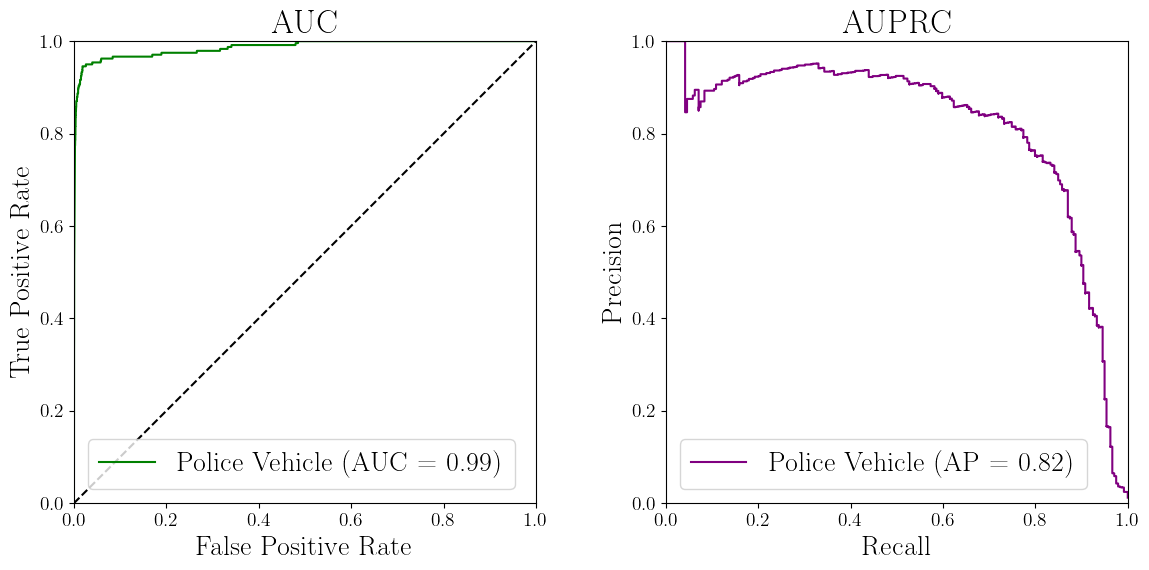

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

fig, (axauc, axprc) = plt.subplots(1, 2, figsize=(14,6))
#plt.style.use('seaborn-v0_8-paper')
RocCurveDisplay.from_predictions(
    t.ground_truth,
    t.Model_predicted_score,
    name="Police Vehicle",
    color="green", ax=axauc
)
axauc.plot([0, 1], [0, 1], "k--")
axauc.axis("square")
axauc.set_xlabel("False Positive Rate", fontsize=20)
axauc.set_ylabel("True Positive Rate", fontsize=20)

#plt.title("ROC Curve")
axauc.legend(prop={'size': 20})
#plt.show()

axauc.set_xlim(0,1)
axauc.set_ylim(0,1)

axauc.tick_params(axis='both', which='major', labelsize=14)
axauc.tick_params(axis='both', which='minor', labelsize=14)

#plt.style.use('seaborn-v0_8-paper')
PrecisionRecallDisplay.from_predictions(
    t.ground_truth,
    t.Model_predicted_score,
    name="Police Vehicle",
    color="purple", ax=axprc
)

axauc.set_title("AUC", fontdict = {'fontsize': 24})

axprc.axis("square")
axprc.set_xlabel("Recall", fontsize=20)
axprc.set_ylabel("Precision", fontsize=20)
#plt.title("ROC Curve")
axprc.legend(prop={'size': 20})
#plt.show()

axprc.set_xlim(0,1)
axprc.set_ylim(0,1)

axprc.tick_params(axis='both', which='major', labelsize=14)
axprc.tick_params(axis='both', which='minor', labelsize=14)

axprc.set_title("AUPRC", fontdict = {'fontsize': 24})

plt.savefig(f"{PAPER_GIT_REPO_PATH}/figures/test_auc_auprc.pdf")

### Tuning: Additional Feature on Calibration Plot for In/Out of Manhattan

In [72]:
tgdf_with_boro = gpd.sjoin(tgdf, nybb)

In [73]:
t["Manhattan"] = tgdf_with_boro['BoroName'] == "Manhattan"

In [74]:
t["Manhattan"].describe()

count     19964
unique        2
top       False
freq      13616
Name: Manhattan, dtype: object

### Calibration Plots 

Optimization terminated successfully.
         Current function value: 0.017230
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           ground_truth   No. Observations:                20046
Model:                          Logit   Df Residuals:                    20043
Method:                           MLE   Df Model:                            2
Date:                Sat, 29 Apr 2023   Pseudo R-squ.:                  0.7335
Time:                        18:50:40   Log-Likelihood:                -345.39
converged:                       True   LL-Null:                       -1296.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -6.6134      0.

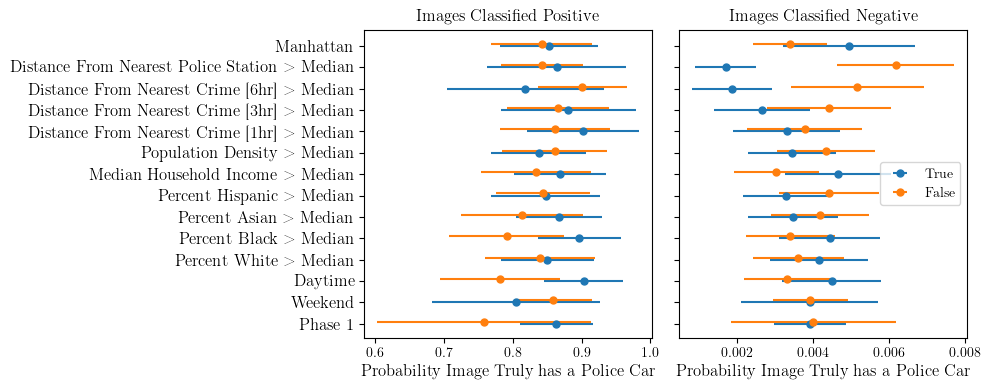

In [75]:
if 'ground_truth' not in t.columns:
    t['ground_truth'] = 0
if 'Model_predicted_score' not in t.columns:
    t['Model_predicted_score'] = 0
else:
    # simple correction model for distance from nearest police station. 
    police_station_model = sm.Logit.from_formula('ground_truth ~ distance_from_nearest_police_station + Model_predicted_score', data=t).fit()
    print(police_station_model.summary())
    t['police_distance_adjusted_score'] = police_station_model.predict(t)

t.loc[t['median_household_income'] == '250,000+', 'median_household_income']  = 250000
t.loc[t['median_household_income'] == '2,500-', 'median_household_income']  = 2500

t.loc[t['median_household_income'] == '-', 'median_household_income'] = None
t['median_household_income'] = t['median_household_income'].astype(float)
t.describe()


t['classified_positive'] = t.Model_predicted_score > 0.86 # what is our threshold for a positive classification
print('p(Police | classified_positive): %2.3f (precision)' % t.loc[t['classified_positive'] == 1, 'ground_truth'].mean())
print('p(Police | classified_negative): %2.3f (forget what this metric is called)' % t.loc[t['classified_positive'] == 0, 'ground_truth'].mean())
print('p(classified_positive | police): %2.3f (recall)' % t.loc[t['ground_truth'] == 1, 'classified_positive'].mean())


results=[]
vars_to_plot = ['phase','weekend','daytime', 'percent_white', 'percent_black', 'percent_asian', 'percent_hispanic', 'median_household_income', 'pplpersqmi', 'distance_from_nearest_crime_1hr', 'distance_from_nearest_crime_3hr', 'distance_from_nearest_crime_6hr', 'distance_from_nearest_police_station', 'Manhattan']
vars_to_plot_names = ['Phase 1', 'Weekend', 'Daytime', 'Percent White > Median', 'Percent Black > Median', 'Percent Asian > Median', 
                      'Percent Hispanic > Median', 'Median Household Income > Median', 'Population Density > Median', 'Distance From Nearest Crime [1hr] > Median', 'Distance From Nearest Crime [3hr] > Median', 'Distance From Nearest Crime [6hr] > Median', 'Distance From Nearest Police Station > Median', 'Manhattan']
for x in vars_to_plot:
    df_to_plot = t.dropna(subset=x).copy()
    if df_to_plot[x].median() == (1 | 0): 
        df_to_plot["above_median"] = df_to_plot[x] == 1
    else:
        df_to_plot['above_median'] = df_to_plot[x] > df_to_plot[x].median()
    
    for above_median in [True, False]:
        for classified_positive in [True, False]:
            idxs = (df_to_plot['above_median'] == above_median) & (df_to_plot['classified_positive'] == classified_positive)
            mu = df_to_plot.loc[idxs, 'ground_truth'].mean() # probability of a police car given whether you're above the median and whether you're classified positive. 
            err = 1.96 * np.sqrt(mu * (1 - mu) / idxs.sum()) # confidence interval: https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
            results.append({'x':x, 
                            'above_median':above_median, 
                            'classified_positive':classified_positive,
                            'mean':mu, 
                            'error':err})
results = pd.DataFrame(results)


fig, (axp, axn) = plt.subplots(1,2, figsize=(10,4), sharey='row')



# positive classifications plot
axp.errorbar(y=range(len(vars_to_plot)),
             x=results.loc[(results['classified_positive'] == True) & (results['above_median'] == True), 'mean'], 
             xerr=results.loc[(results['classified_positive'] == True) & (results['above_median'] == True), 'error'], 
             label='True', 
             fmt='.', 
             markersize=10)
axp.errorbar(y=[a + 0.1 for a in range(len(vars_to_plot))],
             x=results.loc[(results['classified_positive'] == True) & (results['above_median'] == False), 'mean'], 
             xerr=results.loc[(results['classified_positive'] == True) & (results['above_median'] == False), 'error'], 
             label='False', 
             fmt='.', 
             markersize=10)
#axp.legend(loc='center left')
axp.set_yticks(range(len(vars_to_plot)), vars_to_plot_names, fontsize=12)
axp.set_xlabel("Probability Image Truly has a Police Car", fontsize=12)
axp.set_title("Images Classified Positive", fontsize=12)

# negative classifications plot 
axn.errorbar(y=range(len(vars_to_plot)),
             x=results.loc[(results['classified_positive'] == False) & (results['above_median'] == True), 'mean'], 
             xerr=results.loc[(results['classified_positive'] == False) & (results['above_median'] == True), 'error'], 
             label='True', 
             fmt='.', 
             markersize=10)
axn.errorbar(y=[a + 0.1 for a in range(len(vars_to_plot))],
             x=results.loc[(results['classified_positive'] == False) & (results['above_median'] == False), 'mean'], 
             xerr=results.loc[(results['classified_positive'] == False) & (results['above_median'] == False), 'error'], 
             label='False', 
             fmt='.', 
             markersize=10)


axn.legend(loc='center right')
#axn.set_yticks(range(len(vars_to_plot)), '')
axn.set_xlabel("Probability Image Truly has a Police Car", fontsize=12)
axn.set_title("Images Classified Negative", fontsize=12)


plt.tight_layout()

plt.savefig(f"{PAPER_GIT_REPO_PATH}/figures/calplots.pdf")


### AUC/ AUPRC By Subgroups Table 

In [76]:
from sklearn import metrics

# AUC/AUPRC by subgroup as well. 
auc_auprc_results = []
for x in vars_to_plot:
    df_to_plot = t.dropna(subset=x).copy()

    if df_to_plot[x].median() == (1 | 0): 
        df_to_plot["above_median"] = df_to_plot[x] == 1
    else:
        df_to_plot['above_median'] = df_to_plot[x] > df_to_plot[x].median()
    
    for above_median in [True, False]:
        
        auc = metrics.roc_auc_score(y_true=df_to_plot.loc[df_to_plot['above_median'] == above_median,'ground_truth'], 
                                    y_score=df_to_plot.loc[df_to_plot['above_median'] == above_median,'Model_predicted_score'])

        average_precision = metrics.average_precision_score(
            y_true=df_to_plot.loc[df_to_plot['above_median'] == above_median,'ground_truth'], 
            y_score=df_to_plot.loc[df_to_plot['above_median'] == above_median,'Model_predicted_score'])
        auc_auprc_results.append({'x':x, 
                                  'above_median':above_median, 
                                  'auc':auc, 
                                  'auprc':average_precision, 
                                  'n':(df_to_plot['above_median'] == above_median).sum(), 
                                  'n_pos':df_to_plot.loc[df_to_plot['above_median'] == above_median,'ground_truth'].sum()})

#pd.DataFrame(auc_auprc_results).to_csv(f"valset_{os.path.splitext(FILENAME)[0][-1]}_auc_by_subgroup.csv",index=False)

auc_auprc_results_table = pd.DataFrame(auc_auprc_results)

rename = {'x': 'Subgroup', 'above_median': 'Above Median?', 'auc': 'AUC', 'auprc': 'Average Precision'}

auc_auprc_results_table.rename(columns=rename, inplace=True)
auc_auprc_results_table.drop(['n','n_pos'], axis=1, inplace=True)

auc_auprc_results_table = auc_auprc_results_table.groupby(['Subgroup', 'Above Median?'], sort=False).sum().unstack(level=1)

subgroups_print = {'day_of_month': 'Day of Month', 'daytime': 'Daytime', 'distance_from_nearest_crime_1hr': 'Distance From Nearest Crime [1hr] > Median', 'distance_from_nearest_crime_3hr': 'Distance From Nearest Crime [3hr] > Median', 'distance_from_nearest_crime_6hr': 'Distance From Nearest Crime [6hr] > Median', 'distance_from_nearest_police_station': 'Distance From Nearest Police Station > Median', 'median_household_income': 'Median Household Income > Median', 'month': 'Month', 'percent_black': 'Percent Black > Median', 'percent_white': 'Percent White > Median', 'percent_hispanic': 'Percent Hispanic > Median', 'percent_asian': 'Percent Asian > Median', 'phase': 'Phase 1', 'pplpersqmi': 'Population Density > Median', 'weekend': 'Weekend', 'Manhattan': 'Manhattan'}
vars_to_plot_names = ['Phase 1', 'Weekend', 'Daytime', 'Percent White > Median', 'Percent Black > Median', 'Percent Asian > Median', 
                      'Percent Hispanic > Median', 'Median Household Income > Median', 'Population Density > Median', 'Distance From Nearest Crime [1hr] > Median', 'Distance From Nearest Crime [3hr] > Median', 'Distance From Nearest Crime [6hr] > Median', 'Distance From Nearest Police Station > Median']
auc_auprc_results_table.index = auc_auprc_results_table.index.map(subgroups_print)
auc_aurpc_results_table = auc_auprc_results_table.iloc[::-1]
auc_auprc_results_table.to_latex(f'{PAPER_GIT_REPO_PATH}/tables/auc_auprc_results_by_subgroup.tex', float_format="%.2f") 

auc_aurpc_results_table


/tmp/ipykernel_2788316/2689677792.py:44: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  auc_auprc_results_table.to_latex(f'{PAPER_GIT_REPO_PATH}/tables/auc_auprc_results_by_subgroup.tex', float_format="%.2f")


AUC            \
Above Median?                                     True      False   
Subgroup                                                            
Manhattan                                      0.987506  0.984805   
Distance From Nearest Police Station > Median  0.984203  0.986176   
Distance From Nearest Crime [6hr] > Median     0.993866  0.987633   
Distance From Nearest Crime [3hr] > Median     0.988791  0.990227   
Distance From Nearest Crime [1hr] > Median     0.986029  0.993160   
Population Density > Median                    0.988591  0.983917   
Median Household Income > Median               0.988634  0.988154   
Percent Hispanic > Median                      0.992572  0.984402   
Percent Asian > Median                         0.989809  0.985574   
Percent Black > Median                         0.987622  0.984218   
Percent White > Median                         0.986896  0.989425   
Daytime                                        0.981486  0.993018   
Weekend                                        0.982055  0.987572   
Phase 1                                        0.987942  0.977875   

                                              Average Precision            
Above Median?                                             True      False  
Subgroup                                                                   
Manhattan                                              0.827701  0.808892  
Distance From Nearest Police Station > Median          0.828867  0.816135  
Distance From Nearest Crime [6hr] > Median             0.775242  0.841987  
Distance From Nearest Crime [3hr] > Median             0.818921  0.821725  
Distance From Nearest Crime [1hr] > Median             0.820549  0.821906  
Population Density > Median                            0.819663  0.814873  
Median Household Income > Median                       0.812942  0.834325  
Percent Hispanic > Median                              0.842741  0.795858  
Percent Asian > Median                                 0.837024  0.792697  
Percent Black > Median                                 0.857797  0.765305  
Percent White > Median                                 0.813508  0.822547  
Daytime                                                0.814316  0.815717  
Weekend                                                0.765676  0.833260  
Phase 1                                                0.817936  0.805081